# Github README Demo

In [ ]:
import requests
import pandas as pd

data_path = "./dataset/data/esol_iupac.csv"
raw_data = pd.read_csv(data_path)

def query2IUPAC(text):
  try:
    '''This function queries the one given molecule name and returns a SMILES string from the record'''
    #query the PubChem database
    r = requests.get('https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/' + text + '/property/IUPACName/JSON')
    data = r.json()
    smi = data["PropertyTable"]["Properties"][0]["IUPACName"]
    return smi
  except:
    return None

# raw_data["IUPAC"] = raw_data["SMILES"].map(lambda sml: query2IUPAC(sml))
raw_data = raw_data[["IUPAC", "measured log(solubility:mol/L)"]]
raw_data = raw_data.dropna()
raw_data[50:65]

### README example

In [ ]:
import bolift
import openai
from dotenv import load_dotenv
load_dotenv()

asktell = bolift.AskTellFewShotTopk(
    model="gpt-3.5-turbo"
)

asktell.tell("3-chloroaniline", -1.37)
asktell.tell("nitromethane", 0.26)
asktell.tell("1-bromobutane", -2.43)
asktell.tell("3-chlorophenol", -0.7)

yhat = asktell.predict("penta-1,4-diene	")
print(yhat.mean(), yhat.std())

pool_list = [
  "1,5-dimethylnaphthalene",
  "2-aminophenol",
  "1hexa-1,5-diene",
  "1,1,2,3,4,4-hexachlorobuta-1,3-diene"
]
pool=bolift.Pool(pool_list)
print(asktell.ask(pool))

asktell.tell("phenol", -0.5)
yhat = asktell.predict("penta-1,4-diene")
print(yhat.mean(), yhat.std())

# Regression experiments

In [10]:
import bolift
from bolift.llm_model import GaussDist, DiscreteDist
import numpy as np
import json
import pandas as pd
from langchain.prompts.prompt import PromptTemplate
import itertools
import openai
import glob

import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.join(current_dir,'..')
sys.path.insert(0, parent_dir)

from dotenv import load_dotenv
load_dotenv()

np.random.seed(0)

## Utils

In [11]:
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)
# @retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def run_ablation_experiment(asktell, train_data, test_data, system_message=""):
    if isinstance(asktell, bolift.AskTellGPR) or isinstance(asktell, bolift.AskTellFinetuning):
        i=-1 #Hack to pass the case we have len(train_data) == 1
        for i in range(len(train_data)-1):
            asktell.tell(train_data.iloc[i, 0], float(train_data.iloc[i, 1]), train=False)
        asktell.tell(train_data.iloc[i+1, 0], float(train_data.iloc[i+1, 1]), train=True)
    else:
        for i in range(len(train_data)):
            asktell.tell(train_data.iloc[i, 0], float(train_data.iloc[i, 1]))
    x    = []
    y    = []
    yhat = []
    for j in range(len(test_data)):
        x.append(test_data.iloc[j, 0])
        y.append(float(test_data.iloc[j, 1]))
        if isinstance(asktell, bolift.AskTellNearestNeighbor):
            yhat.append(asktell.predict(test_data.iloc[j, 0]))
        else:
            yhat.append(asktell.predict(test_data.iloc[j, 0], system_message=system_message))

    x_filter = [xi for xi, yhi in zip(x, yhat)]# if len(yhi.values) > 0]
    y_filter = [yi for yi, yhi in zip(y, yhat)]# if len(yhi.values) > 0]
    yhat_filter = [yhi for yi, yhi in zip(y, yhat)]# if len(yhi.values) > 0]
    return x_filter, y_filter, yhat_filter

def save_csv(filename, x, y, yhat, data, model, T, k, N, model_class, tokens):
    if not os.path.exists(filename):
        f = open(filename, "w")
        f.write("y;yhat;yprobs;data;model;Temperature;k_selected;N_train;model_class;n_tokens;x\n")
    else:
        f = open(filename, "a")

    for xi, yi, yhi in zip(x, y, yhat):
        # print(yi, yhi, data, model, T, k, N, model_class, tokens, xi)
        if isinstance(yhi, DiscreteDist):
            if len(yhi.values) > 0:
                for v,p in zip(yhi.values, yhi.probs):
                    f.write(f"{yi};{v};{p:.4f};{data};{model};{T};{k};{N};{model_class};{tokens};{xi}\n")
        if isinstance(yhi, GaussDist):
            # f.write(f"{yi};{yhi.mean()};{yhi.std():.4f};{data};{model};{T};{k};{N};{model_class};{tokens};{xi}\n")
            f.write(f"{yi};{yhi.mean()};{0};{data};{model};{T};{k};{N};{model_class};{tokens};{xi}\n")
    f.close()


In [12]:
def get_dataset(data: str, N: int, split=0.8):
    match data:
        case "in-house":
            data_path = "./dataset/data/71023_BO_ready_pool.csv"
            raw_data = pd.read_csv(data_path)

            raw_data['Catalyst'] = raw_data['Prompt'].str.extract(r'(\b[A-Z][a-z]?:[A-Z][a-z]?:[A-Z][a-z]?\b)')
            unique_cat = raw_data['Catalyst'].unique()
            c = {c: 0.2+m*(5/len(unique_cat)) for m, c in enumerate(unique_cat)}
            raw_data['dummy_Completion'] = raw_data['Catalyst'].apply(lambda x: np.random.normal(c[x], 0.05))

            x_name = "Prompt"
            y_name = "dummy_Completion"
        case "ocm":
            data_path = "./dataset/data/12708_ocm_dataset.csv"
            raw_data = pd.read_csv(data_path, sep=";")
            raw_data = raw_data.sample(frac=1).reset_index(drop=True)
            x_name = "prompt"
            y_name = "completion"
        case "biasfree_ocm":
            data_path = "./dataset/data/bias_free_ocmdataset_p_comp.csv"
            raw_data = pd.read_csv(data_path, sep=",")
            raw_data = raw_data.sample(frac=1).reset_index(drop=True)
            x_name = "prompt"
            y_name = "completion"
        case "sol":
            data_path = "./dataset/data/esol_iupac.csv"
            raw_data = pd.read_csv(data_path)
            raw_data = raw_data.dropna()
            raw_data = raw_data[["IUPAC", "measured log(solubility:mol/L)"]]
            x_name = "IUPAC"
            y_name = "measured log(solubility:mol/L)"
        case "alloy":
            data_path = "./dataset/data/charge_transfer_dataset.csv"
            raw_data = pd.read_csv(data_path, sep=",")
            raw_data = raw_data[['prompt', 'completion']]
            raw_data = raw_data.sample(frac=1).reset_index(drop=True)
            x_name = "prompt"
            y_name = "completion"
        case _:
            raise ValueError("Unknown data")
        
    n_data = raw_data.shape[0]
    indexes = np.random.choice(n_data, int(n_data), replace=False)
    train = np.random.choice(n_data, int(n_data * split), replace=False)
    test = np.setdiff1d(np.arange(n_data), train)
    test = np.random.choice(test, min(200, len(test)), replace=False) # limiting too large test set to avoid expense with OpenAI requests

    if N > len(train):
        raise ValueError(f"N must be less than the training set size. Trainin set size: {len(train)}")
    train_data = raw_data.iloc[train, :].reset_index(drop=True)[:N]
    test_data = raw_data.iloc[test, :].reset_index(drop=True)
    # print(f"Dataset size:  \t{n_data}")
    # print(f"Training size: \t{len(train_data)}")
    # print(f"Test size:     \t{len(test_data)}")

    return raw_data, train_data, test_data, indexes, x_name, y_name


In [13]:
def get_asktell(model: str, kwargs: dict = {}, pool: bolift.Pool = None, knn: int = 1):
    match model:
        case "gpt-3.5-turbo-instruct":
            kwargs['model']="gpt-3.5-turbo-instruct"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "gpt-3.5-turbo-0125":
            kwargs['model']="gpt-3.5-turbo-0125"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "gpt-4":
            kwargs['model']="gpt-4"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "gpt-4o":
            kwargs['model']="gpt-4o-2024-05-13"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "gpt-4o-mini":
            kwargs['model']="gpt-4o-mini-2024-07-18"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "haiku":
            kwargs['model'] = "claude-3-haiku-20240307"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "sonnet":
            kwargs['model'] = "claude-3-5-sonnet-20240620"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "opus":
            kwargs['model'] = "claude-3-opus-20240229"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "gpt-4-0125-preview":
            kwargs['model']="gpt-4-0125-preview"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "davinci":
            kwargs['model']="davinci-002"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "gpr":
            s = kwargs['selector_k']
            kwargs['selector_k'] = 0
            kwargs['pool'] = pool if pool else None
            kwargs['n_components'] = 32
            model = bolift.AskTellGPR(**kwargs) 
            del kwargs['pool']
            del kwargs['n_components']
            kwargs['selector_k'] = s
            return model
        case "knn":
            s = kwargs['selector_k']
            del kwargs['selector_k']
            kwargs['knn'] = knn
            model = bolift.AskTellNearestNeighbor(**kwargs)
            del kwargs['knn']
            kwargs['selector_k'] = s
            return model
        case "krr":
            kwargs['alpha'] = 0.5
            model = bolift.AskTellRidgeKernelRegression(**kwargs)
            del kwargs['alpha']
            return model
        case "finetune":
            s = kwargs['selector_k']
            del kwargs['selector_k']
            kwargs['model']="gpt-3.5-turbo"
            model = bolift.AskTellFinetuning(**kwargs)
            kwargs['selector_k'] = s
            return model
        case _:
            raise ValueError("Unknown model")

In [14]:
def run_experiment(exp, dataset, system_message="", *args, **kwargs):
    T_list = exp['T_list']
    k_list = exp['k_list']
    N_list = exp['N_list']
    models_list = exp['models_list']
    out_csv_file = exp['out_csv_file']
    model_class="topk"
    for T, k, N, model in itertools.product(T_list, k_list, N_list, models_list):
        if model == "gpr" and N <= 5: continue # GPR needs at least 5 data points
        print(f"Running {dataset} {model_class} regression with T={T}, k={k}, N={N}, model={model}", end=" ")
        raw_data, train_data, test_data, indexes, x_name, y_name = get_dataset(dataset, N, split=0.8)
        kwargs['temperature'] = T
        kwargs['selector_k'] = k
        pool=None
        if model == "gpr":
            pool = bolift.Pool(raw_data[x_name].tolist())
            # pool = bolift.Pool(train_data[x_name].tolist())
        asktell = get_asktell(model, kwargs=kwargs, pool=pool, knn=5)
        x, y, yhat =  run_ablation_experiment(asktell, train_data, test_data, system_message=system_message)
        save_csv(out_csv_file, x, y, yhat, dataset, model, T, k, N, model_class, asktell.tokens_used)
        print(" --> done")

def save_backup(out_csv_file):
    if os.path.exists(f"{out_csv_file}.csv"):
        i = 1
        while os.path.exists(f"{out_csv_file}{i}.csv"):
            i += 1
        os.rename(f"{out_csv_file}.csv", f"{out_csv_file}{i}.csv")

def merge_exps(out_csv_file):
    save_backup(out_csv_file)
    all_files = glob.glob("regression-results_exp*.csv")
    exps = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0, sep=";")
        exps.append(df)

    frame = pd.concat(exps, axis=0, ignore_index=True)
    frame.to_csv(f"{out_csv_file}.csv", index=False, sep=";")

    for filename in all_files:
        os.remove(filename)


## Config experiment

These values and datasets should be loaded accordingly with the experiments that are being done.
The union of all values considered in our experiments is available below.
    
```python
T_list = [0.01, 0.1, 0.7, 1.0]
k_list = [1, 2, 3, 4, 5]
N_list = [1, 2, 5, 10, 50, 100, 250, 500, 700, 1000]
models_list = ["gpt-3.5-turbo-instruct", "gpt-3.5-turbo-0125", "gpt-4-0125-preview", "gpt-4o" "davinci-002", "KNN", "RNN", "GPR", "FineTunning"]
out_csv_file = "regression_results.csv"
```

In [6]:
exps = {
    "exp_1" : {
        "T_list" : [0.05],
        "k_list" : [1, 2, 5, 10],
        "N_list" : [1000],
        "models_list" : ["gpt-3.5-turbo-0125", "gpt-4-0125-preview", "gpt-4o"],
        "out_csv_file" : "regression-results1.csv",
    }
}

### in-house

In [ ]:
dataset="in-house"
kwargs = dict(
    prefix="",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],
        template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@\nA:",
    x_formatter=lambda x: f"experimental procedure: {x}",
    y_name="CO STY",
    y_formatter=lambda y: f"{y:.2f}",
)

### OCM

In [49]:
dataset="ocm"
# dataset="biasfree_ocm"
kwargs = dict(
    # prefix="You are a bot who knows chemistry and catalysts. " \
    #         "Below, you'll see examples of experimental procedures to synthesize catalysts and the measured C2 yield in a oxidative methane coupling reaction. " \
    #         "The following question should be answered with a number and finished with ###\n",
    prefix="",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],   
        template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@\nA:",
    x_formatter=lambda x: f"experimental procedure: {x}",
    y_name="C2 yield",
    y_formatter=lambda y: f"{y:.2f}",
)

inv_system_message_path = "./prompts/ocm_inv_prompt_1.txt"
system_message_path = "./prompts/ocm_prompt_1.txt"

exps = {
    # "exp_1" : { # Experiment 1 -> Varying k
    #    "k_list" : [1, 2, 10],
    #    "T_list" : [0.05],
    #    "N_list" : [10],
    #     "models_list" : ["gpt-3.5-turbo-0125"],
    #     "out_csv_file" : "regression-results_exp1.csv",
    # },
    "exp_2": { # Experiment 2 -> Varying T
        "T_list" : [0.05], #[0.01, 0.1, 0.5, 1.0, 1.5],
        "k_list" : [5],
        "N_list" : [10],
        "models_list" : ["gpt-3.5-turbo-0125"],
        "out_csv_file" : "regression-results_exp2.csv",
    },
    # "exp_3": { # Experiment 3 -> Varying N
    #     "T_list" : [0.7],
    #     "k_list" : [5],
    #     "N_list" : [1, 5, 10, 25, 50, 100, 250, 500],
    #     "models_list" : ["gpt-3.5-turbo-0125", "krr", "knn", "gpr", "gpt-4o"],
    #     "out_csv_file" : "regression-results_exp3.csv",
    # },
    # "exp_4": { # Experiment 4 -> Varying the model
    #     "T_list" : [0.7],
    #     "k_list" : [5],
    #     "N_list" : [1000],
    #     "models_list" : ["gpt-4o-mini", "finetune", "gpt-4-0125-preview"],
    #     "out_csv_file" : "regression-results_exp4.csv",
    # }
}

### Solubility

In [48]:
dataset="sol"
kwargs = dict(
    prefix="",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],
        template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@\nA:",
    x_formatter=lambda x: f"iupac name {x}",
    y_name="measured log solubility in mols per litre",
    y_formatter=lambda y: f"{y:.2f}",
)

inv_system_message_path = "./prompts/inv_prompt_sol.txt"
system_message_path = "./prompts/prompt_sol.txt"

exps = {
    # "exp_1" : { # Experiment 1 -> Varying k
    #    "k_list" : [1, 2, 5, 10],
    #    "T_list" : [0.05],
    #    "N_list" : [700],
    #     "models_list" : ["gpt-3.5-turbo-0125"],
    #     "out_csv_file" : "regression-results_exp1.csv",
    # },
    # "exp_2": { # Experiment 2 -> Varying T
    #     "T_list" : [0.01, 0.1, 0.5, 1.0, 1.5],
    #     "k_list" : [5],
    #     "N_list" : [700],
    #     "models_list" : ["gpt-3.5-turbo-0125"],
    #     "out_csv_file" : "regression-results_exp2.csv",
    # },
    "exp_3": { # Experiment 3 -> Varying N
        "T_list" : [0.7],
        "k_list" : [5],
        "N_list" : [1, 5, 10, 25, 50, 100, 250, 500],
        "models_list" : ["gpt-4o"], #["gpt-3.5-turbo-0125", "krr", "knn", "gpr", "gpt-4o"],
        "out_csv_file" : "regression-results_exp3.csv",
    },
    # "exp_4": { # Experiment 4 -> Varying the model
    #     "T_list" : [0.7],
    #     "k_list" : [5],
    #     "N_list" : [700],
    #     "models_list" : ["knn", "gpr", "krr", "finetune", "gpt-4o", "gpt-4o-mini", "gpt-4-0125-preview"],
    #     "out_csv_file" : "regression-results_exp4.csv",
    # }
}

### Alloy

In [15]:
dataset = "alloy"
kwargs = dict(
    prefix="",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],
        template="Q: What is the {y_name} of {x}?@@@nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@nA:",
    x_formatter=lambda x: f"the corresponding experimental procedure: {x}",
    y_name="the log(charge transfer) [coulombs/cm²]",  # inverse prompt: If {y_name} is {y}, then {x_name} is @@@n{x}###
    y_formatter=lambda y: f"{y:.2f}",
    selector_k=5,
    temperature=0.7,
)

inv_system_message_path = ".prompts/alloy_inv_prompt_1.txt"
system_message_path = "./prompts/alloy_prompt_1.txt"

exps = {
    # "exp_1" : { # Experiment 1 -> Varying k
    #    "k_list" : [1, 2, 5, 10],
    #    "T_list" : [0.05],
    #    "N_list" : [1000],
    #    "models_list" : ["gpt-3.5-turbo-0125"],
    #    "out_csv_file" : "regression-results_exp1.csv",
    # },
    # "exp_2": { # Experiment 2 -> Varying T
    #     "T_list" : [0.01, 0.1, 0.5, 1.0, 1.5],
    #     "k_list" : [5],
    #     "N_list" : [1000],
    #     "models_list" : ["gpt-3.5-turbo-0125"],
    #     "out_csv_file" : "regression-results_exp2.csv",
    # },
    "exp_3": {  # Experiment 3 -> Varying N
        "T_list": [0.7],
        "k_list": [5],
        "N_list": [1, 5, 10, 25, 50, 100, 250, 500, 1000],
        "models_list": ["davinci"],  # ["gpt-3.5-turbo-0125", "krr", "knn", "gpr", "gpt-4o"],
        "out_csv_file": "regression-results_exp3.csv",
    },
    # "exp_4": { # Experiment 4 -> Varying the model
    #     "T_list" : [0.7],
    #     "k_list" : [5],
    #     "N_list" : [1000],
    #     "models_list" : ["knn", "gpr", "krr", "finetune", "gpt-4o", "gpt-4o-mini", "gpt-4-0125-preview"],
    #     "out_csv_file" : "regression-results_exp4.csv",
    # }
}


## Run Regression

In [ ]:
df = pd.read_csv("./out/regression/ocm-regression-2.csv", sep=";")
df = df.query("model == 'gpt-3.5-turbo-0125' & N_train == 1000 & k_selected == 5 & Temperature == 1.5")
# df = df.query("model == 'gpt-4o' & N_train == 700 & k_selected == 5 & Temperature == 0.7  & x == '9,10-dimethylanthracene'")
# df = df.query("model == 'gpt-3.5-turbo-0125' & N_train == 700 & k_selected == 5 & Temperature == 0.7")
# df = df.query("model == 'gpt-4-0125-preview' & N_train == 700 & k_selected == 5 & Temperature == 0.7")
# df = df.query("model == 'gpr' & N_train == 700 & k_selected == 5 & Temperature == 0.7")
# print(df)

# plot y by yhat
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_context("talk")

plt.figure(figsize=(5, 5))
sns.scatterplot(data=df, x="y", y="yhat", hue="model", style="model")
# plt.plot([-10, 2], [-10, 2], color="black", linestyle="--")
plt.plot([0, 20], [0, 20], color="black", linestyle="--")
plt.xlabel("True value")
plt.ylabel("Predicted value")
# plt.ylim(-10, 10)
# plt.xlim(-10, 5)
plt.legend().remove()
plt.show()


# Plot results

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import uncertainty_toolbox as uct
import matplotlib as mpl
import matplotlib.font_manager as font_manager
urllib.request.urlretrieve('https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf', 'IBMPlexMono-Regular.ttf')
fe = font_manager.FontEntry(
    fname='IBMPlexMono-Regular.ttf',
    name='plexmono')
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update({'axes.facecolor':'#f5f4e9',
            'grid.color' : '#AAAAAA',
            'axes.edgecolor':'#333333',
            'figure.facecolor':'#FFFFFF',
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': fe.name,
            'font.size': 16,
            'figure.figsize': (3.5,3.5 / 1.2),
            'ytick.left': True,
            'xtick.bottom': True
           })

## Utils

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import log_loss

def mse(y, pred):
  # return np.mean((y-pred)**2)
  return mean_squared_error(y, pred)

def mae(y, pred):
  return mean_absolute_error(y, pred)

def r2(y, pred):
  return r2_score(y, pred)

def corr(y, pred):
  return np.corrcoef(y, pred)[0,1]

def acc(y, pred, threshold):
  acc = sum((abs(pred - y)<threshold))/len(pred)
  return acc

def log_likelihood(y, pred, ystd, eps=0):
  y = np.array(y)
  pred = np.array(pred)
  ystd = np.array(ystd)
  yvar = ystd**2 + eps
  neg_ll = 0.5 * (np.log(yvar) + ((y - pred)**2 / yvar))
  return np.sum(neg_ll)/len(y)

def select_df(df, data, k, T, model, model_class, N):
  config = {'k': k,
            'T': T,
            'data': data,
            'model': model,
            'model_class': model_class,
            'N': N,
            }

  q = f""
  if T != 'any':
    q += f"Temperature=={T} and "
  if k != 'any':  
    q+= f"k_selected=={k} and "
  if model != 'any': 
    q+= f"model=='{model}' and "
  q+= f"model_class=='{model_class}' and "
  if N != 'any':
    q+= f"N_train=={N} and "
  q += f"data=='{data}'"
  sel = df.query(q)
  if sel.empty:
    raise ValueError(f"Dataframe is empty for the configuration {config}")
  return sel

In [18]:
def plot_parities(df, data_property, data_range, nrows, ncols, data=None, k=None, T=None, model=None, model_class=None, N=None, axis_name=None, calibration=None, recal_ind=1, out_name=None, GPR=False):
  config = {'k': k,
            'T': T,
            'data': data,
            'model': model,
            'model_class': model_class,
            'N': N,
            }

  if sum([1 for i in config.values() if i is None]) > 1:
    raise ValueError("Only the property being varied in data_range can be passed as None.")

  if nrows*ncols < len(data_range):
    raise ValueError('''There's not enough space to plat all data in data_range.
    Decrease the size of data_range or increase ncols/nrows.''')

  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharey=False, figsize=(6*ncols, 6*nrows), dpi=300)
  for i, p in enumerate(data_range):
    config[data_property] = p
    y=[]
    yhat=[]
    yprob=[]
    ax = axs if ncols*nrows == 1 else axs.flatten()[i]

    df_sel = select_df(df, **config)

    for prompt in df_sel['x'].unique():
        y.append(df_sel[df_sel['x']==prompt]['y'].unique()[0])
        # max_p = np.argmax(df_sel[df_sel['y']==d]['yprobs'].values)
        yhat.append(df_sel[df_sel['x']==prompt]['yhat'].values)
        yprob.append(df_sel[df_sel['x']==prompt]['yprobs'].values)
    yprobs = [yhi.std() for yhi in yhat]
    if config['model'] in ["gpr", 'knn', 'krr']:
        ymeans = np.array([yhi.mean() for yhi in yhat])
        ystds = np.array([ypi.mean() for ypi in yprob])
    else:
        ymeans = np.array([
                  np.sum(yhi*ypi) if len(yhi)>1 else yhi.mean()
                  for yhi,ypi in zip(yhat, yprob)
                ])
        ystds = np.array([
                  np.sqrt(np.sum((yhi-ymi)**2*ypi)) if np.sum((yhi-ymi)**2*ypi)>1 else 0.1 #ypi.mean()
                  for yhi,ypi,ymi in zip(yhat, yprob, ymeans)
                ])

    if calibration:
        if calibration == "scaling_factor":
          std_scaling = uct.recalibration.optimize_recalibration_ratio(ymeans[:recal_ind], ystds[:recal_ind], np.array(y[:recal_ind]), criterion="miscal")
          ystds = ystds * std_scaling
        elif calibration == "isotonic":
          exp_props, obs_props= uct.metrics_calibration.get_proportion_lists_vectorized(ymeans[:recal_ind], ystds[:recal_ind], np.array(y[:recal_ind]))
          recal_model = uct.recalibration.iso_recal(exp_props, obs_props)
          recal_bounds = uct.metrics_calibration.get_prediction_interval(ymeans, ystds, 0.95, recal_model)
          ystds=np.array([ymeans - recal_bounds.lower,
                 recal_bounds.upper - ymeans])

    ax.plot(y,y)
    if config['model'] not in ['knn', 'krr']:
      ax.errorbar(y, 
                  ymeans, 
                  yerr=ystds,
                  fmt='.', color='gray', alpha=0.3)
    ax.scatter(
        y, ymeans, s=6, alpha=1, color=f"C{i}"
    )
    
    ax.set_title(f"{data_property}={p}")

    lim = (min(y)-1, max(y)+1)
    
    if config['model'] in ["krr", "knn"]:
       metrics = {
          "accuracy": uct.metrics.get_all_accuracy_metrics(ymeans, np.array(y), verbose=False)
                  }
    else:
        metrics = uct.metrics.get_all_metrics(ymeans, ystds, np.array(y), verbose=False)
    ax.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 1*0.1*(max(y)-min(y)), f"$(\\uparrow$)correlation = {metrics['accuracy']['corr']:.3f}")
    if config['model'] not in ["krr", "knn"]:
      ax.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 2*0.1*(max(y)-min(y)), f"$(\\downarrow$)neg-ll = {metrics['scoring_rule']['nll']:.3f}")
    ax.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 3*0.1*(max(y)-min(y)), f"$(\\downarrow$)MAE = {metrics['accuracy']['mae']:.3f}")

    ax.set_ylim(lim[0],lim[1])
    ax.set_xlim(lim[0],lim[1])

    ax.set_xlabel(f"measured {axis_name}")
    if (i%ncols==0):
      ax.set_ylabel(f"predicted {axis_name}")

  plt.tight_layout()
  if (out_name):
    plt.savefig(f"./out/figs/{out_name}", dpi=300)
  plt.show()

In [19]:
def plot_ablation(df, data_property, data_range, nrows, ncols, data=None, k=None, T=None, model=None, model_class=None, N=None, out_name=None, GPR=False):
  config = {'k': k,
            'T': T,
            'data': data,
            'model': model,
            'model_class': model_class,
            'N': N,
            }

  MAE_list = []
  RMSE_list = []
  r_list = []
  nll_list = []
  prop_list = []
  for i, p in enumerate(data_range):
    config[data_property] = p
    y=[]
    yhat=[]
    yprobs=[]
    yprob=[]	

    df_sel = select_df(df, **config)

    for prompt in df_sel['x'].unique():
        y.append(df_sel[df_sel['x']==prompt]['y'].unique()[0])
        # max_p = np.argmax(df_sel[df_sel['y']==d]['yprobs'].values)
        yhat.append(df_sel[df_sel['x']==prompt]['yhat'].values)
        yprob.append(df_sel[df_sel['x']==prompt]['yprobs'].values)
    yprobs = [yhi.std() for yhi in yhat]
    if GPR:
        ymeans = np.array([yhi.mean() for yhi in yhat])
        ystds = np.array([ypi.mean() for ypi in yprob])
    else:
        ymeans = np.array([
                  np.sum(yhi*ypi) if len(yhi)>1 else yhi.mean()
                  for yhi,ypi in zip(yhat, yprob)
                ])
        ystds = np.array([
                  np.sqrt(np.sum((yhi-ymi)**2*ypi)) if yhi.std()>1 else ypi.mean()
                  for yhi,ypi,ymi in zip(yhat, yprob, ymeans)
                ])

    metrics = uct.metrics.get_all_metrics(ymeans, ystds, np.array(y), verbose=False)
    r_list.append(metrics['accuracy']['corr'])
    RMSE_list.append(metrics['accuracy']['rmse'])
    MAE_list.append(metrics['accuracy']['mae'])
    nll_list.append(metrics['scoring_rule']['nll'])
    prop_list.append(p)
    print(f"{model_class}(N:{config['N']}/k:{config['k']}/T:{config['T']}) => RMSE: | MAE: {MAE_list[-1]} | r: {r_list[-1]} | nll: {nll_list[-1]}")

  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharey=False, figsize=(4*ncols, 4*nrows), dpi=300)
  
  axs[0].plot(prop_list, MAE_list)
  axs[0].set_xlabel(data_property)
  axs[0].set_ylabel("$\\rightarrow$MAE")
  
  axs[1].plot(prop_list, r_list)
  axs[1].set_xlabel(data_property)
  axs[1].set_ylabel("$\\leftarrow$correlation")

  axs[2].plot(prop_list, nll_list)
  axs[2].set_xlabel(data_property)
  axs[2].set_yscale('log')
  axs[2].set_ylabel("$\\rightarrow$negative log-likelihood")

  plt.tight_layout()
  # plt.show()
  if (out_name):
    plt.savefig(f"./out/figs/{out_name}", dpi=300)

In [20]:
def get_sub_ablation_data(df, data_property, data_range, data=None, k=None, T=None, model=None, model_class=None, N=None, GPR=False):
  config = {'k': k,
          'T': T,
          'data': data,
          'model': model,
          'model_class': model_class,
          'N': N,
          }
   
  MAE_list = []
  RMSE_list = []
  r_list = []
  nll_list = []
  prop_list = []
  for i, p in enumerate(data_range):
    config[data_property] = p
    y=[]
    yhat=[]
    yprobs=[]
    yprob=[]

    df_sel = select_df(df, **config)

    for prompt in df_sel['x'].unique():
        y.append(df_sel[df_sel['x']==prompt]['y'].unique()[0])
        # max_p = np.argmax(df_sel[df_sel['y']==d]['yprobs'].values)
        yhat.append(df_sel[df_sel['x']==prompt]['yhat'].values)
        yprob.append(df_sel[df_sel['x']==prompt]['yprobs'].values)
    yprobs = [yhi.std() for yhi in yhat]
    if GPR:
        ymeans = np.array([yhi.mean() for yhi in yhat])
        ystds = np.array([ypi.mean() for ypi in yprob])
    else:
        ymeans = np.array([
                  np.sum(yhi*ypi) if len(yhi)>1 else yhi.mean()
                  for yhi,ypi in zip(yhat, yprob)
                ])
        ystds = np.array([
                  np.sqrt(np.sum((yhi-ymi)**2*ypi)) if np.sum((yhi-ymi)**2*ypi)>0 else 10
                  for yhi,ypi,ymi in zip(yhat, yprob, ymeans)
                ])

    if model_class in ["KRR", "KNN"]:
       metrics = {
          "accuracy": uct.metrics.get_all_accuracy_metrics(ymeans, np.array(y), verbose=False)
                  }
    else:
      metrics = uct.metrics.get_all_metrics(ymeans, ystds, np.array(y), verbose=False)
      nll_list.append(metrics['scoring_rule']['nll'])
    r_list.append(metrics['accuracy']['corr'])
    RMSE_list.append(metrics['accuracy']['rmse'])
    MAE_list.append(metrics['accuracy']['mae'])
    prop_list.append(p)
    with open("Table.tex", "a") as t:
      # t.write(f"{config['data']}&{model_class}&{model}&{config['T']}&{config['k']}&{config['N']}&{RMSE_list[-1]}&{MAE_list[-1]}&{r_list[-1]}&{nll_list[-1] if nll_list else '-'}&\\\\\n")
      t.write(f"{model_class}(N:{config['N']}/k:{config['k']}/T:{config['T']}) => RMSE: | MAE: {MAE_list[-1]} | r: {r_list[-1]} | nll: {nll_list[-1]}\n")
   
  return prop_list, MAE_list, r_list, nll_list

def create_sub_ablation(axs, df, lims, data_property, data_range, color='C0', data=None, k=None, T=None, model=None, model_class=None, N=None, label=False, GPR=False):
  config = {'k': k,
            'T': T,
            'data': data,
            'model': model,
            'model_class': model_class,
            'N': N,
            }

  prop_list, MAE_list, r_list, nll_list = get_sub_ablation_data(df, data_property, data_range, **config, GPR=GPR)

  for ax in axs:
    ax.label_outer()

  if label:
    if model_class=="GPR-BOT":
      axs[0].plot(prop_list, MAE_list, label="GPR", color=color)
    else:
      axs[0].plot(prop_list, MAE_list, label=model_class, color=color)
  else:
    axs[0].plot(prop_list, MAE_list, color=color)
  axs[0].set_ylabel("MAE\n$\leftarrow$")
  axs[0].set_ylim(lims[0])
  axs[0].set_label(model_class)
  
  axs[1].plot(prop_list, r_list, color=color)
  axs[1].set_xlabel(data_property)
  axs[1].set_ylabel("r\n$\\rightarrow$")
  axs[1].set_ylim(lims[1])
  axs[1].set_label(model_class)

  if False: #model_class not in ["KRR", "KNN"]:
    axs[2].plot(prop_list, nll_list, color=color)
    axs[2].set_xlabel(data_property)
    axs[2].set_yscale('log')
    axs[2].set_ylabel("neg-ll\n$\leftarrow$")
    # axs[1].set_label(model_class)

  for ax in axs:
    ax.label_outer()

In [21]:
def create_sub_shadow(axs, df, lims, data_property, data_range, color='C0', data=None, k=None, T=None, model=None, model_class=None, N=None, label=False, GPR=False):

    all_MAE = []
    all_r = []
    config = {'k': k,
            'T': T,
            'data': data,
            'model': model,
            'model_class': model_class,
            'N': N,
            }

    for i in range(1, 6):  # Loop through the 5 CSV files
        df = pd.read_csv(f"./out/regression/{data}-regression-{i}.csv", sep=';')
        df_sel = select_df(df, **config)

        prop_list, MAE_list, r_list, nll_list = get_sub_ablation_data(df_sel, data_property, data_range, data=data, k=k, T=T, model=model, model_class=model_class, N=N)

        all_MAE.append(MAE_list)
        all_r.append(r_list)

    all_MAE = np.array(all_MAE)
    all_r = np.array(all_r)

    # Compute average MAE and r
    avg_MAE = np.mean(all_MAE, axis=0)
    avg_r = np.mean(all_r, axis=0)

    # Compute min and max for uncertainty region
    min_MAE = np.min(all_MAE, axis=0)
    max_MAE = np.max(all_MAE, axis=0)
    min_r = np.min(all_r, axis=0)
    max_r = np.max(all_r, axis=0)

    # Plot average curve with uncertainty region
    axs[0].fill_between(prop_list, min_MAE, max_MAE, color=color, alpha=0.1)
    if label:
        axs[0].plot(prop_list, avg_MAE, color=color, label=f"{model}") #label=f"N={N}")
    else:
        axs[0].plot(prop_list, avg_MAE, color=color)
    axs[0].set_ylabel("MAE\n$\leftarrow$")
    axs[0].set_ylim(lims[0])

    axs[1].fill_between(prop_list, min_r, max_r, color=color, alpha=0.1)
    axs[1].plot(prop_list, avg_r, color=color)
    axs[1].set_ylabel("r\n$\\rightarrow$")
    axs[1].set_ylim(lims[1])

    axs[1].set_xlabel(data_property)

    for ax in axs:
        ax.label_outer()

In [22]:
def get_sub_parity_data():
   pass
   

def create_sub_parity(ax, df_sel, axis_name, model_class, lim=[-1,1], color='gray', GPR=False, title=None, calibration=None, recal_ind=0):
    y=[]
    yhat=[]
    yprob=[]
    for prompt in df_sel['x'].unique():
        y.append(df_sel[df_sel['x']==prompt]['y'].unique()[0])
        # max_p = np.argmax(df_sel[df_sel['y']==d]['yprobs'].values)
        yhat.append(df_sel[df_sel['x']==prompt]['yhat'].values)
        yprob.append(df_sel[df_sel['x']==prompt]['yprobs'].values)
    yprobs = [yhi.std() for yhi in yhat]
    if GPR:
        ymeans = np.array([yhi.mean() for yhi in yhat])
        ystds = np.array([ypi.mean() for ypi in yprob])
    else:
        ymeans = np.array([
                  np.sum(yhi*ypi) if len(yhi)>1 else yhi.mean()
                  for yhi,ypi in zip(yhat, yprob)
                ])
        ystds = np.array([
                  np.sqrt(np.sum((yhi-ymi)**2*ypi)) if len(yhi)>1 else ypi.mean()
                  for yhi,ypi,ymi in zip(yhat, yprob, ymeans)
                ])
        # hack to fix uncertainties in finetuned model. 3.559 is the training set (N=1000) std
        ystds = np.array([ysi if ysi!=10 else 3.559 for ysi in ystds]) 
  
    if calibration:
        if calibration == "scaling_factor":
          std_scaling = uct.recalibration.optimize_recalibration_ratio(ymeans[:recal_ind], ystds[:recal_ind], np.array(y[:recal_ind]),
                                                                        criterion="miscal")
          ystds = ystds * std_scaling
        elif calibration == "isotonic":
          exp_props, obs_props= uct.metrics_calibration.get_proportion_lists_vectorized(ymeans[:recal_ind], ystds[:recal_ind], np.array(y[:recal_ind]))
          recal_model = uct.recalibration.iso_recal(exp_props, obs_props)
          recal_bounds = uct.metrics_calibration.get_prediction_interval(ymeans, ystds, 0.95, recal_model)
          ystds=np.array([ymeans - recal_bounds.lower,
                 recal_bounds.upper - ymeans])

    if model_class in ["KRR", "KNN"] or calibration=="isotonic":
       metrics = {
          "accuracy": uct.metrics.get_all_accuracy_metrics(ymeans, np.array(y), verbose=False)
                  }
    else:
      metrics = uct.metrics.get_all_metrics(ymeans, ystds, np.array(y), verbose=False)
      ax.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 2*0.1*(max(y)-min(y)), f"$(\\downarrow$)neg-ll = {metrics['scoring_rule']['nll']:.3f}")
    ax.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 1*0.1*(max(y)-min(y)), f"$(\\uparrow$)correlation = {metrics['accuracy']['corr']:.3f}")
    ax.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 3*0.1*(max(y)-min(y)), f"$(\\downarrow$)MAE = {metrics['accuracy']['mae']:.3f}")

    # with open("Table.tex", "a") as t:
    #   t.write(f"{config['data']}&{model_class}&{model}&{config['T']}&{config['k']}&{config['N']}&{RMSE_list[-1]}&{MAE_list[-1]}&{r_list[-1]}&{nll_list[-1] if nll_list else '-'}&\\\\\n")
    # print(f"{model_class}(N:{config['N']}/k:{config['k']}/T:{config['T']}) => RMSE: | MAE: {MAE_list[-1]} | r: {r_list[-1]} | nll: {nll_list[-1]}")
    print(metrics['accuracy']['rmse'])

    ax.set_xlabel(f"measured {axis_name}")
    ax.set_ylabel(f"predicted {axis_name}")
    ax.set_ylim(lim[0],lim[1])
    ax.set_xlim(lim[0],lim[1])
    ax.set_xticks(np.arange(lim[0],lim[1]+0.1,4.0))

    if title:
      ax.set_title(title)

    ax.plot(y,y)
    ax.plot(lim,lim)
    if model_class not in ["KRR", "KNN"]:
      ax.errorbar(y, 
                  ymeans, 
                  yerr=ystds,
                  fmt='.', color='gray', alpha=0.2)
    ax.scatter(
        y, ymeans, s=6, alpha=1, color=color
    )

## Loading results

In [75]:
data = "ocm"
df = pd.read_csv(f"./out/regression/{data}-regression-1.csv", sep=';')

df.groupby(['Temperature', 'data', 'k_selected', 'model_class', "N_train", "model"]).size().reset_index().sort_values(by=["model_class", "Temperature"]).head(50)

,Temperature,data,k_selected,model_class,N_train,model,0
0,0.01,ocm,5,topk,10,gpt-3.5-turbo-0125,219
1,0.01,ocm,5,topk,1000,gpt-3.5-turbo-0125,217
2,0.05,ocm,1,topk,10,gpt-3.5-turbo-0125,301
3,0.05,ocm,1,topk,1000,gpt-3.5-turbo-0125,294
4,0.05,ocm,2,topk,10,gpt-3.5-turbo-0125,304
5,0.05,ocm,2,topk,1000,gpt-3.5-turbo-0125,283
6,0.05,ocm,5,topk,10,gpt-3.5-turbo-0125,382
7,0.05,ocm,5,topk,1000,gpt-3.5-turbo-0125,290
8,0.05,ocm,10,topk,10,gpt-3.5-turbo-0125,301
9,0.05,ocm,10,topk,1000,gpt-3.5-turbo-0125,346


### Getting values for tables

In [76]:
i=0
for k in df.groupby(['Temperature', 'data', 'k_selected', 'model_class', "N_train", "model"]).size().items():
  config = {
    "T": k[0][0],
    "data": k[0][1],
    "k": k[0][2],
    "model_class": k[0][3],
    "N": k[0][4],
    "model": k[0][5]
    }
  if (config['model'] != 'gpt-3.5-turbo-0125'):
    continue
  MAE_list = []
  r_list = []
  nll_list = []
  for d in range(1,6):
    df_data = pd.read_csv(f"./out/regression/{data}-regression-{d}.csv", sep=';')
    _, MAE, r, nll = (get_sub_ablation_data(
      df_data,
      'T',
      [config['T']],
      **config
    ))
    MAE_list.append(MAE)
    r_list.append(r)
    nll_list.append(nll)
  print(MAE_list)
  MAE = f"{np.mean(MAE_list):.3f} $\pm$ {np.std(MAE_list):.3f}"
  r = f"{np.mean(r_list):.3f} $\pm$ {np.std(r_list):.3f}"
  nll = f"{np.mean(nll_list):.3f} $\pm$ {np.std(nll_list):.3f}"
  print(f"{config['data']} & {config['model']} & {config['N']} & {config['k']} & {config['T']} & {MAE} & {r} & {nll} \\\\")

[[2.7006200000000002], [3.16335], [3.2416], [4.12219], [2.76856]]
ocm & gpt-3.5-turbo-0125 & 10 & 5 & 0.01 & 3.199 $\pm$ 0.508 & 0.210 $\pm$ 0.117 & 5122.271 $\pm$ 5909.929 \\
[[2.3549800000000003], [2.15699], [2.3393], [2.1763500000000002], [2.34399]]
ocm & gpt-3.5-turbo-0125 & 1000 & 5 & 0.01 & 2.274 $\pm$ 0.088 & 0.507 $\pm$ 0.022 & 1328.537 $\pm$ 1502.254 \\
[[5.26621], [3.84999], [3.689095], [2.8646799999999994], [3.6484499999999995]]
ocm & gpt-3.5-turbo-0125 & 10 & 1 & 0.05 & 3.864 $\pm$ 0.780 & 0.181 $\pm$ 0.150 & 7490.464 $\pm$ 4723.215 \\
[[3.08722], [3.0156400000000003], [2.66832], [2.5487100000000003], [2.85807]]
ocm & gpt-3.5-turbo-0125 & 1000 & 1 & 0.05 & 2.836 $\pm$ 0.203 & 0.447 $\pm$ 0.035 & 13046.086 $\pm$ 16116.083 \\
[[3.4606899999999996], [2.5313299999999996], [4.1546199999999995], [3.7978000000000005], [3.44465]]
ocm & gpt-3.5-turbo-0125 & 10 & 2 & 0.05 & 3.478 $\pm$ 0.540 & 0.155 $\pm$ 0.080 & 11216.684 $\pm$ 10871.278 \\
[[2.27448], [2.64859], [2.57459], [2.19020

In [74]:
import scipy.stats as stats
if data == "sol":
  k1  = [[1.0908636363636364], [1.1832598870056499], [1.107522727272727], [1.0762272727272728], [1.1438977272727273]]
  k2  = [[1.11002976], [0.8684180790960453], [0.8408965000000002], [0.9627853107344634], [1.0231186440677966]]
  k5  = [[0.9103059195402298], [0.8706489545454545], [0.8120227272727273], [0.8247669999999999], [0.9803472228571429]]
  k10 = [[0.7593220338983051], [0.7492159090909092], [0.7352485875706215], [0.8086420454545454], [0.8401704545454546]]

  T005= [[0.7593220338983051], [0.7492159090909092], [0.7352485875706215], [0.8086420454545454], [0.8401704545454546]]
  T01 = [[0.8530621468926555], [0.7789261363636364], [0.9502429378531072], [0.877632768361582], [0.8452282799999998]]
  T05 = [[0.8854375], [0.8310738636363637], [0.7516704545454546], [0.7844463276836157], [0.7561931818181818]]
  T07 = [[0.8991412429378532], [0.9568920454545455], [0.8579661016949152], [0.9325657142857143], [0.9250056497175141]]
  T10 = [[0.8618056497175142], [0.9817514772727273], [0.8911016949152541], [0.901593220338983], [0.8558632768361583]]
  T15 = [[1.2489462146892654], [5.357642372881355], [4.827120338983051], [2.8245785211428576], [1.0188261016949154]]

  N1 = [[2.0263502824858755], [3.0606704545454546], [3.4375480225988695], [2.6423107344632766], [2.804628571428572]]
  N5 = [[4.139926553672316], [3.1915340909090912], [2.9207627118644077], [3.1079209039548026], [2.5827570621468925]]
  N10 = [[3.267217142857143], [1.7852556818181817], [2.3478079096045197], [1.8715762711864408], [2.600423728813559]]
  N25 = [[2.9626875], [2.569715909090909], [2.4330847457627116], [1.9673045977011496], [3.5702114285714286]]
  N50 = [[1.5130170454545455], [1.66475], [1.7277485714285714], [1.683819209039548], [1.655960227272727]]
  N100 = [[1.9340227272727275], [1.1884204545454544], [1.2817175141242936], [1.565090395480226], [1.6075254237288137]]
  N250 = [[1.1768361581920905], [1.107834285714286], [1.016813559322034], [1.1411355932203389], [1.2918863636363638]]
  N500 = [[0.9542329545454546], [0.9800625], [1.0103977272727271], [1.1243465909090908], [0.9609209039548022]]
  N1000 = [[0.8991412429378532], [0.9568920454545455], [0.8579661016949152], [0.9325657142857143], [0.9250056497175141]]

if data == "ocm":
  k1  = [[3.08722], [3.0156400000000003], [2.66832], [2.5487100000000003], [2.85807]]
  k2  = [[2.27448], [2.64859], [2.57459], [2.1902000000000004], [2.12223]]
  k5  = [[2.4873600000000002], [2.4017700000000004], [2.4468], [2.8101100000000003], [2.5714699999999997]]
  k10 = [[2.6273400000000002], [2.36714], [2.64697], [2.5841], [2.50021]]

  T005= [[2.4873600000000002], [2.4017700000000004], [2.4468], [2.8101100000000003], [2.5714699999999997]]
  T01 = [[2.20297], [2.35719], [2.15844], [2.39386], [2.15257]]
  T05 = [[2.53152], [2.49365], [2.24776], [2.21711], [2.4835499999999997]]
  T07 = [[2.10888], [2.0664500000000006], [2.2181300000000004], [2.242], [2.4587]]
  T10 = [[2.19661], [2.20766], [2.2488], [2.33529], [2.2955099999999997]]
  T15 = [[3.2579315], [2.6343252], [3.058765529389575], [2.3256620000000003], [2.6990995]]

  N1 = [[2.84001], [3.4121799999999998], [3.1467888000000004], [6.42114], [3.5210100000000004]]
  N5 = [[2.6150300000000004], [3.2023600000000005], [3.14168], [3.05443], [2.5317000000000003]]
  N10 = [[5.16586], [4.16284], [2.90985], [4.08717], [3.6658600000000003]]
  N25 = [[2.81358], [2.9238299999999997], [2.8903700000000003], [3.2587200000000003], [3.05932]]
  N50 = [[3.0023400000000002], [2.9152], [3.1592600000000006], [3.0529], [2.7846699999999998]]
  N100 = [[3.0850400000000002], [3.01153], [3.054440000000001], [3.2039], [3.10955]]
  N250 = [[2.84294], [2.5029700000000004], [2.9302499999999996], [2.94748], [3.4290999999999996]]
  N500 = [[2.79453], [2.7104200000000005], [2.85055], [2.38013], [2.5443100000000003]]
  N1000 = [[2.10888], [2.0664500000000006], [2.2181300000000004], [2.242], [2.4587]]



print(f"Data: {data}")
print(f"Dependence on k. Tests for H0: Both samples have the same mean.")
print(f"test      | d1  | d2   | p-value | Results")
print(f"t-test    | k=1 | k=2  | {stats.ttest_ind(k1, k2).pvalue[0]:.5f} | {stats.ttest_ind(k1, k2)}")
print(f"t-test    | k=2 | k=5 | {stats.ttest_ind(k2, k5).pvalue[0]:.5f} | {stats.ttest_ind(k1, k10)}")
print(f"t-test    | k=2 | k=10 | {stats.ttest_ind(k2, k10).pvalue[0]:.5f} | {stats.ttest_ind(k2, k10)}")
print(f"t-test    | k=5 | k=10 | {stats.ttest_ind(k5, k10).pvalue[0]:.5f} | {stats.ttest_ind(k5, k10)}")
print("-"*80)
print(f"Dependence on T. Tests for H0: Both samples have the same mean.")
print(f"test      | d1  | d2   | p-value | Results")
print(f"t-test    | T=0.05 | T=0.1  | {stats.ttest_ind(T005, T01).pvalue[0]:.5f} | {stats.ttest_ind(T005, T01)}")
print(f"t-test    | T=0.1  | T=0.5  | {stats.ttest_ind(T01, T05).pvalue[0]:.5f} | {stats.ttest_ind(T01, T05)}")
print(f"t-test    | T=0.5  | T=0.7  | {stats.ttest_ind(T05, T07).pvalue[0]:.5f} | {stats.ttest_ind(T05, T07)}")
print(f"t-test    | T=0.7  | T=1.0  | {stats.ttest_ind(T07, T10).pvalue[0]:.5f} | {stats.ttest_ind(T07, T10)}")
print(f"t-test    | T=1.0  | T=1.5  | {stats.ttest_ind(T10, T15).pvalue[0]:.5f} | {stats.ttest_ind(T10, T15)}")
print("-"*80)
print(f"Dependence on N. Tests for H0: Both samples have the same mean.")
print(f"test      | d1  | d2   | p-value | Results")
print(f"t-test    | N=1 | N=5  | {stats.ttest_ind(N1, N5).pvalue[0]:.5f} | {stats.ttest_ind(N1, N5)}")
print(f"t-test    | N=5 | N=10 | {stats.ttest_ind(N5, N10).pvalue[0]:.5f} | {stats.ttest_ind(N5, N10)}")
print(f"t-test    | N=10 | N=25 | {stats.ttest_ind(N10, N25).pvalue[0]:.5f} | {stats.ttest_ind(N10, N25)}")
print(f"t-test    | N=25 | N=50 | {stats.ttest_ind(N25, N50).pvalue[0]:.5f} | {stats.ttest_ind(N25, N50)}")
print(f"t-test    | N=50 | N=100 | {stats.ttest_ind(N50, N100).pvalue[0]:.5f} | {stats.ttest_ind(N50, N100)}")
print(f"t-test    | N=100 | N=250 | {stats.ttest_ind(N100, N250).pvalue[0]:.5f} | {stats.ttest_ind(N100, N250)}")
print(f"t-test    | N=250 | N=500 | {stats.ttest_ind(N250, N500).pvalue[0]:.5f} | {stats.ttest_ind(N250, N500)}")
print(f"t-test    | N=500 | N=1k | {stats.ttest_ind(N500, N1000).pvalue[0]:.5f} | {stats.ttest_ind(N500, N1000)}")
print("-"*80)
print(f"Dependence on k. Tests for H0: Both samples originates from the same distribution")
print(f"test      | d1  | d2   | p-value | Results")
print(f"KS-test   | k=1 | k=2  | {stats.ks_2samp(k1, k2).pvalue[0]:.5f} | {stats.ks_2samp(k1, k2)}")
print(f"KS-test   | k=1 | k=10 | {stats.ks_2samp(k1, k10).pvalue[0]:.5f} | {stats.ks_2samp(k1, k10)}")
print(f"KS-test   | k=2 | k=10 | {stats.ks_2samp(k2, k10).pvalue[0]:.5f} | {stats.ks_2samp(k2, k10)}")
print(f"KS-test   | k=5 | k=10 | {stats.ks_2samp(k5, k10).pvalue[0]:.5f} | {stats.ks_2samp(k5, k10)}")
print(f"M-W U-test| k=1 | k=2  | {stats.mannwhitneyu(k1, k2).pvalue[0]:.5f} | {stats.mannwhitneyu(k1, k2)}")
print(f"M-W U-test| k=1 | k=10 | {stats.mannwhitneyu(k1, k10).pvalue[0]:.5f} | {stats.mannwhitneyu(k1, k10)}")
print(f"M-W U-test| k=2 | k=10 | {stats.mannwhitneyu(k2, k10).pvalue[0]:.5f} | {stats.mannwhitneyu(k2, k10)}")
print(f"M-W U-test| k=5 | k=10 | {stats.mannwhitneyu(k5, k10).pvalue[0]:.5f} | {stats.mannwhitneyu(k5, k10)}")


Data: ocm
Dependence on k. Tests for H0: Both samples have the same mean.
test      | d1  | d2   | p-value | Results
t-test    | k=1 | k=2  | 0.01196 | TtestResult(statistic=array([3.23534544]), pvalue=array([0.01196076]), df=array([8.]))
t-test    | k=2 | k=5 | 0.19324 | TtestResult(statistic=array([2.5528949]), pvalue=array([0.03402104]), df=array([8.]))
t-test    | k=2 | k=10 | 0.15653 | TtestResult(statistic=array([-1.56365021]), pvalue=array([0.15652814]), df=array([8.]))
t-test    | k=5 | k=10 | 0.98559 | TtestResult(statistic=array([-0.01863485]), pvalue=array([0.98558878]), df=array([8.]))
--------------------------------------------------------------------------------
Dependence on T. Tests for H0: Both samples have the same mean.
test      | d1  | d2   | p-value | Results
t-test    | T=0.05 | T=0.1  | 0.01115 | TtestResult(statistic=array([3.28206282]), pvalue=array([0.0111534]), df=array([8.]))
t-test    | T=0.1  | T=0.5  | 0.13083 | TtestResult(statistic=array([-1.68321975]

In [ ]:
gpt3 = [15.88, 15.77, 16.07, 18.9, 19.34]
gpt4 = [12.67, 17.1, 20.88, 20.15, 19.43]
gpr =  [18.191, 18.192, 18.193, 18.194, 18.195]

print(stats.ttest_ind(gpr, gpt4))
print(stats.ks_2samp(gpr, gpt4))

## Plotting

### Paper Figures

In [23]:
data  = "alloy"

files_path = "./out/regression"
max_N = 1000 if data=="ocm" else 700

ValueError: Dataframe is empty for the configuration {'k': 'any', 'T': 0.05, 'data': 'alloy', 'model': 'gpt-3.5-turbo-0125', 'model_class': 'topk', 'N': 700}

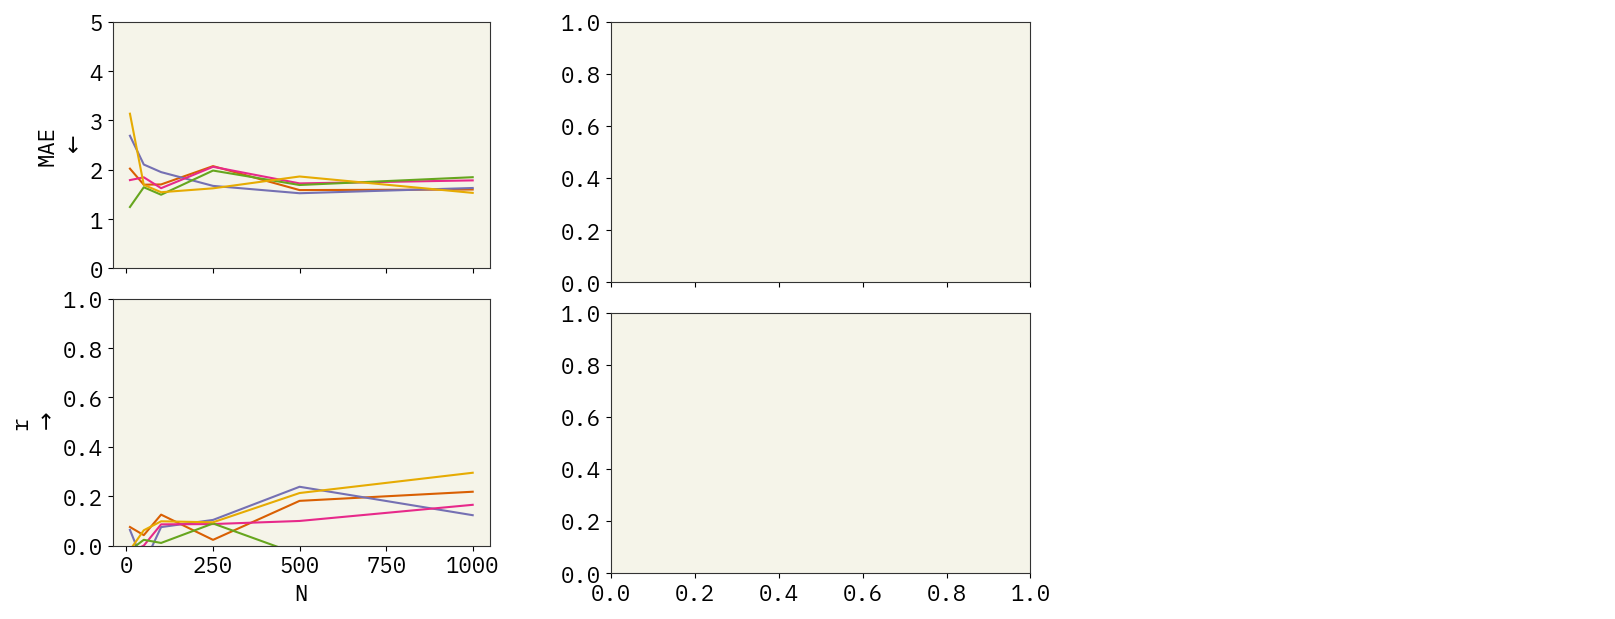

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def make_ablation_fig():
  fig = plt.figure(figsize=(16,6), constrained_layout=True)
  subfigs = fig.subfigures(1,3, wspace=0.1, hspace=0.1)

  lims = [(0,5),(0,1),(-1,1)]

  sub00 = subfigs[0].subplots(2,1, sharex=True, sharey=False)
  df1 = pd.read_csv(f"{files_path}/{data}-regression-1.csv", sep=';')
  d01 = select_df(df1, data=data, k=5, T=0.7, model='gpt-3.5-turbo-0125', model_class='topk', N='any')
  create_sub_ablation(sub00, d01, lims, 'N', sorted(d01['N_train'].unique()), data=data, color='C1', k=5, T=0.7, model='gpt-3.5-turbo-0125', model_class='topk', N=None, label=False)
  df2 = pd.read_csv(f"{files_path}/{data}-regression-2.csv", sep=';')
  d02 = select_df(df2, data=data, k=5, T=0.7, model='gpt-3.5-turbo-0125', model_class='topk', N='any')
  create_sub_ablation(sub00, d02, lims, 'N', sorted(d02['N_train'].unique()), data=data, color='C2', k=5, T=0.7, model='gpt-3.5-turbo-0125', model_class='topk', N=None, label=False)
  df3 = pd.read_csv(f"{files_path}/{data}-regression-3.csv", sep=';')
  d03 = select_df(df3, data=data, k=5, T=0.7, model='gpt-3.5-turbo-0125', model_class='topk', N='any')
  create_sub_ablation(sub00, d03, lims, 'N', sorted(d03['N_train'].unique()), data=data, color='C3', k=5, T=0.7, model='gpt-3.5-turbo-0125', model_class='topk', N=None, label=False)
  df4 = pd.read_csv(f"{files_path}/{data}-regression-4.csv", sep=';')
  d04 = select_df(df4, data=data, k=5, T=0.7, model='gpt-3.5-turbo-0125', model_class='topk', N='any')
  create_sub_ablation(sub00, d04, lims, 'N', sorted(d04['N_train'].unique()), data=data, color='C4', k=5, T=0.7, model='gpt-3.5-turbo-0125', model_class='topk', N=None, label=False)
  df5 = pd.read_csv(f"{files_path}/{data}-regression-5.csv", sep=';')
  d05 = select_df(df5, data=data, k=5, T=0.7, model='gpt-3.5-turbo-0125', model_class='topk', N='any')
  create_sub_ablation(sub00, d05, lims, 'N', sorted(d05['N_train'].unique()), data=data, color='C5', k=5, T=0.7, model='gpt-3.5-turbo-0125', model_class='topk', N=None, label=False)

  sub02 = subfigs[1].subplots(2,1, sharex=True, sharey=False)
  df1 = pd.read_csv(f"{files_path}/{data}-regression-1.csv", sep=';')
  d01 = select_df(df1, data=data, k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=max_N)
  create_sub_ablation(sub02, d01, lims, 'k', sorted(d01['k_selected'].unique()), data=data, color='C1', k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=max_N, label=False)
  df2 = pd.read_csv(f"{files_path}/{data}-regression-2.csv", sep=';')
  d02 = select_df(df2, data=data, k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=max_N)
  create_sub_ablation(sub02, d02, lims, 'k', sorted(d02['k_selected'].unique()), data=data, color='C2', k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=max_N, label=False)
  df3 = pd.read_csv(f"{files_path}/{data}-regression-3.csv", sep=';')
  d03 = select_df(df3, data=data, k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=max_N)
  create_sub_ablation(sub02, d03, lims, 'k', sorted(d03['k_selected'].unique()), data=data, color='C3', k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=max_N, label=False)
  df4 = pd.read_csv(f"{files_path}/{data}-regression-4.csv", sep=';')
  d04 = select_df(df4, data=data, k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=max_N)
  create_sub_ablation(sub02, d04, lims, 'k', sorted(d04['k_selected'].unique()), data=data, color='C4', k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=max_N, label=False)
  df5 = pd.read_csv(f"{files_path}/{data}-regression-5.csv", sep=';')
  d05 = select_df(df5, data=data, k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=max_N)
  create_sub_ablation(sub02, d05, lims, 'k', sorted(d05['k_selected'].unique()), data=data, color='C5', k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=max_N, label=False)

  sub03 = subfigs[2].subplots(2,1, sharex=True, sharey=False)
  df1 = pd.read_csv(f"{files_path}/{data}-regression-1.csv", sep=';')
  d01 = select_df(df1, data=data, k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=max_N)
  create_sub_ablation(sub03, d01, lims, 'T', sorted(d01['Temperature'].unique()), data=data, color='C1', k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=max_N, label=False)
  df2 = pd.read_csv(f"{files_path}/{data}-regression-2.csv", sep=';')
  d02 = select_df(df2, data=data, k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=max_N)
  create_sub_ablation(sub03, d02, lims, 'T', sorted(d02['Temperature'].unique()), data=data, color='C2', k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=max_N, label=False)
  df3 = pd.read_csv(f"{files_path}/{data}-regression-3.csv", sep=';')
  d03 = select_df(df3, data=data, k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=max_N)
  create_sub_ablation(sub03, d03, lims, 'T', sorted(d03['Temperature'].unique()), data=data, color='C3', k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=max_N, label=False)
  df4 = pd.read_csv(f"{files_path}/{data}-regression-4.csv", sep=';')
  d04 = select_df(df4, data=data, k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=max_N)
  create_sub_ablation(sub03, d04, lims, 'T', sorted(d04['Temperature'].unique()), data=data, color='C4', k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=max_N, label=False)
  df5 = pd.read_csv(f"{files_path}/{data}-regression-5.csv", sep=';')
  d05 = select_df(df5, data=data, k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=max_N)
  create_sub_ablation(sub03, d05, lims, 'T', sorted(d05['Temperature'].unique()), data=data, color='C5', k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=max_N, label=False)


  # fig.legend(loc='upper center', bbox_to_anchor=(0.5 ,0),
  #           fancybox=True, shadow=True, ncol=6)

  # plt.tight_layout()
  plt.savefig(f"./out/figs/{data}_metrics", dpi=300, bbox_inches='tight')
  plt.show()

make_ablation_fig()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


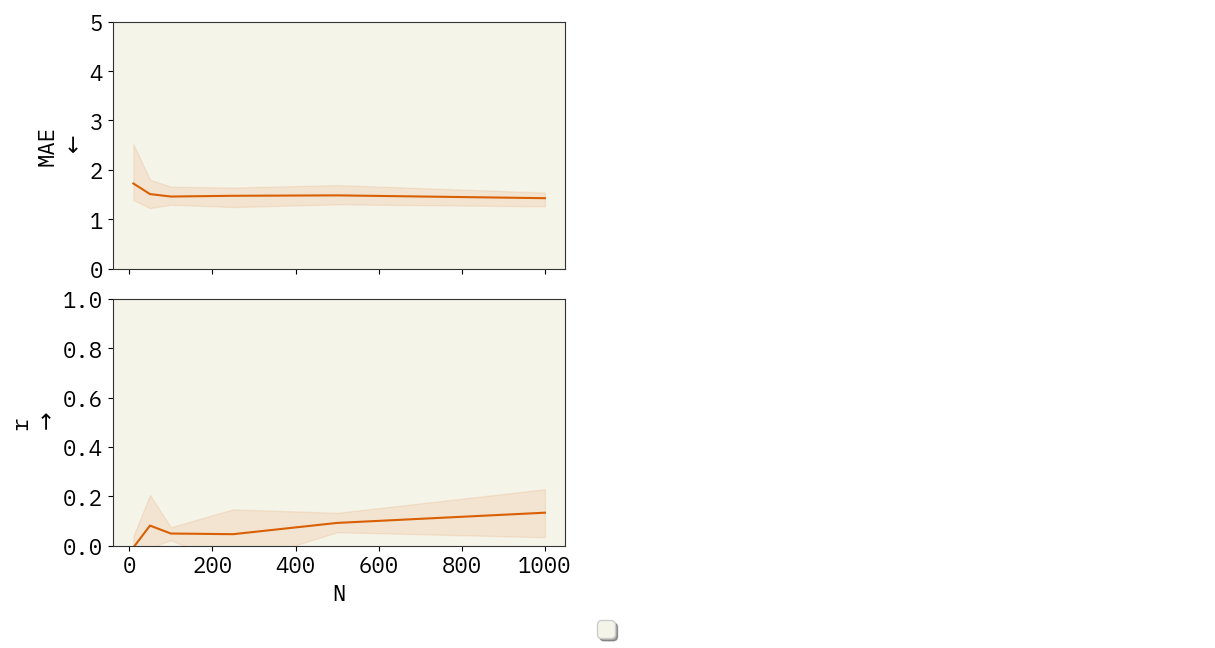

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def make_sub_shadow_fig():
  fig = plt.figure(figsize=(12,6), constrained_layout=True)
  subfigs = fig.subfigures(1,2, wspace=0.1, hspace=0.1) 

  lims = [(0,5),(0,1),(-1,1)]

  df0 = pd.read_csv(f"{files_path}/{data}-regression-1.csv", sep=';')

  sub00 = subfigs[0].subplots(2,1, sharex=True, sharey=False)
  d00 = select_df(df0, data=data, k=5, T=0.7, model='gpt-4o', model_class='topk', N='any')
  create_sub_shadow(sub00, d00, lims, 'N', sorted(d00['N_train'].unique()), data=data, color='C1', k=5, T=0.7, model='gpt-4o', model_class='topk', N='any', label=False)

  # sub01 = subfigs[1].subplots(2,1, sharex=True, sharey=False)
  # d01 = select_df(df0, data=data, k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=max_N)
  # create_sub_shadow(sub01, d01, lims, 'k', sorted(d01['k_selected'].unique()), data=data, color='C1', k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=max_N, label=True)
  # create_sub_shadow(sub01, d01, lims, 'k', sorted(d01['k_selected'].unique()), data=data, color='C2', k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=10, label=True)

  # sub02 = subfigs[2].subplots(2,1, sharex=True, sharey=False)
  # d02 = select_df(df0, data=data, k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=max_N)
  # create_sub_shadow(sub02, d02, lims, 'T', sorted(d02['Temperature'].unique()), data=data, color='C1', k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=max_N, label=False)
  # create_sub_shadow(sub02, d02, lims, 'T', sorted(d02['Temperature'].unique()), data=data, color='C2', k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=10, label=False)

  fig.legend(loc='upper center', bbox_to_anchor=(0.5 ,0),
            fancybox=True, shadow=True, ncol=6)

  # plt.tight_layout()
  plt.savefig(f"./out/figs/{data}_metrics_shaded", dpi=300, bbox_inches='tight')
  plt.show()

make_sub_shadow_fig()

/Users/maykcaldas/miniconda3/envs/bolift/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/maykcaldas/miniconda3/envs/bolift/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/maykcaldas/miniconda3/envs/bolift/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/maykcaldas/miniconda3/envs/bolift/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


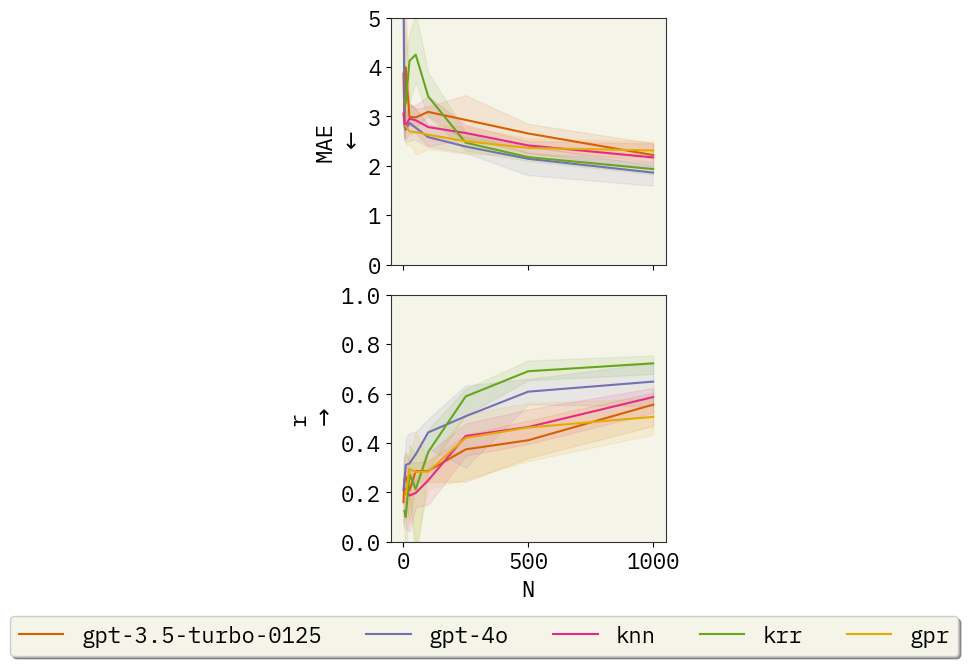

In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def make_shadow_models_fig():

  fig = plt.figure(figsize=(4,6), constrained_layout=True)
  subfigs = fig.subfigures(1,1, wspace=0.1, hspace=0.1) 

  lims = [(0,5),(0,1),(-1,1)]

  sub00 = subfigs.subplots(2,1, sharex=True, sharey=False)
  df0 = pd.read_csv(f"{files_path}/{data}-regression-1.csv", sep=';')
  d00 = select_df(df0, data=data, k=5, T=0.7, model='gpt-3.5-turbo-0125', model_class='topk', N='any')
  create_sub_shadow(sub00, d00, lims, 'N', sorted(d00['N_train'].unique()), data=data, color='C1', k=5, T=0.7, model='gpt-3.5-turbo-0125', model_class='topk', N='any', label=True)
  d01 = select_df(df0, data=data, k=5, T=0.7, model='gpt-4o', model_class='topk', N='any')
  create_sub_shadow(sub00, d01, lims, 'N', sorted(d01['N_train'].unique()), data=data, color='C2', k=5, T=0.7, model='gpt-4o', model_class='topk', N='any', label=True)
  d02 = select_df(df0, data=data, k=5, T=0.7, model='knn', model_class='topk', N='any')
  create_sub_shadow(sub00, d02, lims, 'N', sorted(d02['N_train'].unique()), data=data, color='C3', k=5, T=0.7, model='knn', model_class='topk', N='any', label=True)
  d03 = select_df(df0, data=data, k=5, T=0.7, model='krr', model_class='topk', N='any')
  d03 = d03[d03['N_train']!=1]
  create_sub_shadow(sub00, d03, lims, 'N', sorted(d03['N_train'].unique()), data=data, color='C4', k=5, T=0.7, model='krr', model_class='topk', N='any', label=True)
  d04 = select_df(df0, data=data, k=5, T=0.7, model='gpr', model_class='topk', N='any')
  create_sub_shadow(sub00, d04, lims, 'N', sorted(d04['N_train'].unique()), data=data, color='C5', k=5, T=0.7, model='gpr', model_class='topk', N='any', label=True)

  fig.legend(loc='upper center', bbox_to_anchor=(0.5 ,0),
            fancybox=True, shadow=True, ncol=5)

  # plt.tight_layout()
  plt.savefig(f"./out/figs/{data}_metrics_models", dpi=300, bbox_inches='tight')
  plt.show()

make_shadow_models_fig()

In [16]:
df = pd.read_csv(f"{files_path}/{data}-regression-2.csv", sep=';')
df.columns

plot_data = df[(df['data'] == data)]

In [ ]:
plot_parities(df, 
              'model', 
              ["gpt-3.5-turbo-0125", "gpt-4-0125-preview", "gpt-4o", "krr", "finetune", "gpr"],
              nrows=2, ncols=3,
              data=data, 
              k=5,
              T=0.7,
              model=None,
              model_class='topk',
              N=max_N,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield" if data=="ocm" else "LogS solubility",
              out_name=f"{data}_parities_models")

In [ ]:
plot_parities(df, 
              'N', 
              [1,50,250,max_N],
              nrows=1, ncols=4,
              data=data, 
              k=5, 
              T=0.7, 
              model='gpt-3.5-turbo-0125', 
              model_class='topk', 
              N=None,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield" if data=="ocm" else "LogS solubility",
              out_name=f"{data}_par_gpt3.5_N.png")

plot_parities(df, 
              'k', 
              [1,2,5,10],
              nrows=1, ncols=4,
              data=data, 
              k=None, 
              T=0.05, 
              model='gpt-3.5-turbo-0125', 
              model_class='topk', 
              N=max_N,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield" if data=="ocm" else "LogS solubility",
              out_name=f"{data}_par_gpt3.5_k.png")

plot_parities(df, 
              'T', 
              [0.01,0.1,0.5,0.7,1.0,1.5],
              nrows=2, ncols=3,
              data=data, 
              k=5, 
              T=None, 
              model='gpt-3.5-turbo-0125', 
              model_class='topk', 
              N=max_N,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield" if data=="ocm" else "LogS solubility",
              out_name=f"{data}_par_gpt3.5_T.png")

### OCM

In [24]:
df = pd.read_csv(f"{files_path}/{data}-regression-5.csv", sep=';')
df.columns

c2_data = df[(df['data'] == 'ocm')]
# c2_data.groupby(['Temperature', 'data', 'k_selected', 'model_class', "N_train", "model"]).size().reset_index().sort_values(by=["model_class", "Temperature"])

#### topk

In [ ]:
plot_parities(df, 
              'model', 
              ["gpt-3.5-turbo-0125", "gpt-4-0125-preview", "gpt-4o", "knn", "finetune", "gpr"],
              nrows=2, ncols=3,
              data='ocm', 
              k=5,
              T=0.7,
              model=None,
              model_class='topk',
              N=1000,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield",
              out_name="ocm_parities_models")

In [ ]:
plot_parities(df, 
              'N', 
              [1,50,250,1000], #sorted(c2_data[(c2_data['model_class']=="topk") & (c2_data['model']=="text-curie-001")]['N_train'].unique()), 
              nrows=1, ncols=4,
              data='ocm', 
              k=5, 
              T=0.7, 
              model='gpt-3.5-turbo-0125', 
              model_class='topk', 
              N=None,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield",
              out_name="ocm_par_gpt3.5_N.png")

plot_parities(df, 
              'k', 
              [1,2,5,10], #sorted(c2_data[(c2_data['model_class']=="topk") & (c2_data['model']=="text-curie-001")]['k_selected'].unique()), 
              nrows=1, ncols=4,
              data='ocm', 
              k=None, 
              T=0.05, 
              model='gpt-3.5-turbo-0125', 
              model_class='topk', 
              N=1000,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield",
              out_name="ocm_par_gpt3.5_k.png")

plot_parities(df, 
              'T', 
              [0.01,0.1,0.5,0.7,1.0,1.5], #sorted(c2_data[(c2_data['model_class']=="topk") & (c2_data['model']=="text-curie-001")]['k_selected'].unique()), 
              nrows=2, ncols=3,
              data='ocm', 
              k=5, 
              T=None, 
              model='gpt-3.5-turbo-0125', 
              model_class='topk', 
              N=1000,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield",
              out_name="ocm_par_gpt3.5_T.png")

#### GPR

In [ ]:
plot_parities(c2_data, 
              'N', 
              [1000], #sorted(c2_data[(c2_data['model_class']=="GPR-BOT") & (c2_data['model']=="text-ada-001")]['N_train'].unique()), 
              nrows=1, ncols=4,
              data='C2', 
              k=5, 
              T=0.7, 
              model='gpr', 
              model_class='topk', 
              N=None,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield",
              out_name="par_C2_GPR_N.png",
              GPR=True)

#### KNN

In [ ]:
plot_parities(c2_data, 
              'N', 
              [5, 50, 500, 1000], #sorted(c2_data[(c2_data['model_class']=="GPR-BOT") & (c2_data['model']=="text-ada-001")]['N_train'].unique()), 
              nrows=1, ncols=4,
              data='ocm', 
              k=5, 
              T=0.7, 
              model='krr', 
              model_class='topk', 
              N=None,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield",
              out_name="par_ocm_KNN_N.png",
              GPR=True)

#### finetune

In [ ]:
plot_parities(c2_data, 
              'N', 
              [50,100,250,1000], #sorted(c2_data[(c2_data['model_class']=="finetune")]['N_train'].unique()), 
              nrows=1, ncols=4,
              data='C2', 
              k=0, 
              T=0.05, 
              model='any', 
              model_class='finetune', 
              N=None,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield",
              out_name="par_C2_FT_N.png")

In [ ]:
# plot_ablation(df, 
#               'N', 
#               sorted(c2_data[(c2_data['model_class']=="finetune")]['N_train'].unique()), 
#               nrows=1, ncols=3,
#               data='C2',
#               k=0,
#               T=0.05,
#               model='any',
#               model_class='finetune',
#               N=None,
#               out_name="ablation_C2_FT_N_ada.png")

### Solubility

In [ ]:
df = pd.read_csv("./out/regression/sol-regression-1.csv", sep=';')
df.columns

iupac_sol_data = df[(df['data'] == 'sol')]
iupac_sol_data.groupby(['Temperature', 'data','k_selected', 'model_class', "N_train", "model"]).size().reset_index().sort_values(by=["model_class", "Temperature"])

In [ ]:
plot_parities(df, 
              'model', 
              ["gpt-3.5-turbo-0125", "gpt-4-0125-preview", "gpt-4o", "knn", "krr", "gpr"],
              nrows=2, ncols=3,
              data='sol', 
              k=5,
              T=0.7,
              model=None,
              model_class='topk',
              N=700,
              calibration=None,
              recal_ind=300,
              axis_name="LogS solubility",
              out_name="parities-sol-models")

#### topk

In [ ]:
plot_parities(iupac_sol_data, 
              'N', 
              [1,10,250,700], #sorted(iupac_sol_data[iupac_sol_data['model_class']=="topk"]['N_train'].unique()), 
              nrows=1, ncols=4,
              data='sol', 
              k=5, 
              T=0.7, 
              model='gpt-3.5-turbo-0125', 
              model_class='topk',
              N=None,
              calibration=None,
              recal_ind=300,
              axis_name="LogS solubility",
              out_name="par_sol_gpt-3.5_N.png")

plot_parities(iupac_sol_data, 
              'k', 
              [1,2,5,10], #sorted(iupac_sol_data[iupac_sol_data['model_class']=="multi"]['N_train'].unique()), 
              nrows=1, ncols=4,
              data='sol', 
              k=None,
              T=0.05, 
              model='gpt-3.5-turbo-0125', 
              model_class='topk', 
              N=700,
              calibration=None,
              recal_ind=300,
              axis_name="LogS solubility",
              out_name="par_sol_gpt-3.5_k.png")

plot_parities(iupac_sol_data, 
              'T', 
              [0.05, 0.5, 0.7, 1.0], #sorted(iupac_sol_data[iupac_sol_data['model_class']=="multi"]['N_train'].unique()), 
              nrows=1, ncols=4,
              data='sol', 
              k=5,
              T=None, 
              model='gpt-3.5-turbo-0125', 
              model_class='topk', 
              N=700,
              calibration=None,
              recal_ind=300,
              axis_name="LogS solubility",
              out_name="par_sol_gpt-3.5_T.png")

#### GPR

In [ ]:
plot_parities(iupac_sol_data, 
              'N', 
              [1,10,250,700], #sorted(iupac_sol_data[(iupac_sol_data['model_class']=="GPR-BOT") & (iupac_sol_data['model']=="text-ada-001")]['N_train'].unique()), 
              nrows=1, ncols=4,
              data='iupac-sol', 
              k=32, 
              T=0.05, 
              model='text-ada-001', 
              model_class='GPR-BOT', 
              N=None,
              calibration=None,
              recal_ind=300,
              axis_name="LoS solubility",
              out_name="par_sol_GPR_N.png",
              GPR=True)

In [ ]:
plot_ablation(df, 
              'N', 
              sorted(iupac_sol_data[(iupac_sol_data['model_class']=="GPR-BOT") & (iupac_sol_data['model']=="text-ada-001")]['N_train'].unique()), 
              nrows=1, ncols=3,
              data='iupac-sol',
              k=32,
              T=0.05,
              model='text-ada-001',
              model_class='GPR-BOT',
              N=None,
              out_name="ablation_sol_GPR_N_ada.png")

#### KNN

In [ ]:
plot_parities(iupac_sol_data, 
              'N', 
              [5,10,25,50,100,250,500,700], #sorted(c2_data[(c2_data['model_class']=="GPR-BOT") & (c2_data['model']=="text-ada-001")]['N_train'].unique()), 
              nrows=2, ncols=4,
              data='iupac-sol', 
              k=1, 
              T=0.05, 
              model='text-ada-001', 
              model_class='KNN', 
              N=None,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield",
              out_name="par_sol_KNN_N.png",
              GPR=True)

#### finetune

In [ ]:
plot_parities(iupac_sol_data, 
              'N', 
              [50, 250, 700],#sorted(iupac_sol_data[iupac_sol_data['model_class']=="finetune"]['N_train'].unique()), 
              nrows=1, ncols=3,
              data='iupac-sol', 
              k=0, 
              T=0.05, 
              model='any', 
              N=None,
              axis_name="LogS solubility",
              out_name="par_sol_FT_N.png")

In [ ]:
plot_ablation(iupac_sol_data, 
              'N', 
              sorted(iupac_sol_data[iupac_sol_data['model_class']=="finetune"]['N_train'].unique()), 
              nrows=1, ncols=3,
              data='iupac-sol',
              k=0,
              T=0.05,
              model='any',
              model_class='finetune',
              N=None,
              out_name="ablation_sol_FT_N_ada.png")

### Calibrated MMR vs Sim

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,12), constrained_layout=True)
for ax in axs.flat:
    ax.set_aspect(1)

d00 = select_df(df, data="C2", k=5, T=0.7, model='text-curie-001', model_class='topk_NN', N=1000)
lim_c2 = (min(d00['y']), max(d00['y']))
lim_c2 = (-2, 25)
text_anchor = sum(lim_c2)/len(lim_c2)
create_sub_parity(axs[0], d00, 'C2 yield', lim=lim_c2, model_class="topk_NN", color=f'C4', title="topk_cos_sim|N=1000|T=.7|k=5|curie",calibration='scaling_factor',recal_ind=300)

d00 = select_df(df, data="C2", k=5, T=0.7, model='text-curie-001', model_class='multi_NN', N=1000)
lim_c2 = (min(d00['y']), max(d00['y']))
lim_c2 = (-2, 25)
text_anchor = sum(lim_c2)/len(lim_c2)
create_sub_parity(axs[1], d00, 'C2 yield', lim=lim_c2, model_class="multi_NN", color=f'C4', title="multi_cos_sim|N=1000|T=.7|k=5|curie",calibration='scaling_factor',recal_ind=300)


plt.show()

### Calibration Curves

In [ ]:


def create_sub_parity(ax, df_sel, axis_name="topk",model_class="topk", lim=[-1,1], color='gray', GPR=False, Type_cali =False,rec_split=100,model='curie-001'):
   
    def process_data(df, unique_vals):
        y, yhat, yprob = [], [], []
        for prompt in unique_vals:
            y.append(df[df['x'] == prompt]['y'].unique()[0])
            yhat.append(df[df['x'] == prompt]['yhat'].values)
            yprob.append(df[df['x'] == prompt]['yprobs'].values)
        return y, yhat, yprob

    def calculate_means_and_stds(yhat, yprob):
        means = np.array([np.sum(yhi * ypi) if len(yhi) > 1 else ypi.mean() for yhi, ypi in zip(yhat, yprob)])
        means = np.where(means == 0, 0.0001, means)
        stds = np.array([np.sqrt(np.sum((yhi - ymi)**2 * ypi)) if len(yhi) > 1 else ypi.mean() for yhi, ypi, ymi in zip(yhat, yprob, means)])
        return means, stds

    unique_vals = df_sel['x'].unique()
    y, yhat, yprob = process_data(df_sel, unique_vals[:rec_split])
    y_rec, yhat_rec, yprob_rec = process_data(df_sel, unique_vals[rec_split:])

    ymeans, ystds = calculate_means_and_stds(yhat, yprob)
    ymeans_rec, ystds_rec = calculate_means_and_stds(yhat_rec, yprob_rec)
    
    if Type_cali == "cali":

        if GPR:
            yprobs = np.array([ypi.mean() for ypi in yprob])

            yhats=np.array(np.concatenate(yhat))

            ma = uct.miscalibration_area(yhats,yprobs, np.array(y), recal_model=None)
            
            x, y1 = uct.get_proportion_lists_vectorized(yhats,yprobs, np.array(y))
            
            ax.plot(x,x, linestyle= '--')
            ax.plot(x, y1)
            ax.fill_between(x, x, y1, color='teal', alpha=0.3)
            
            ax.set_title(' {} | {} | {}'.format(model,axis_name, model_class))
           
            ax.set_ylim(lim[0],lim[1])
            ax.set_xlim(lim[0],lim[1])
            ax.set_ylabel("Observed Proportion in Interval")
            
            # ax.(lim[0] + 0.1*(max(yhat)-min(yhat)), lim[1] - 1*0.1*(max(yhat)-min(y)), f"(\u2193)Miscalibration area = {ma:.3f}")

            ax.annotate(f"(\u2193)Miscalibration area = {ma:.3f}",
                xy=(0.02, 0.98), xycoords='axes fraction',
                horizontalalignment='left', verticalalignment='top')

        else:
            ma = uct.miscalibration_area(ymeans,ystds, np.array(y), recal_model=None)
            
            x, y1 = uct.get_proportion_lists_vectorized(ymeans,ystds, np.array(y))
            
            ax.plot(x,x, linestyle= '--')
            ax.plot(x, y1)
            ax.fill_between(x, x, y1, color='teal', alpha=0.3)
            
            ax.set_title(' {} | {} | {}'.format(model,axis_name, model_class))
            # ax.set_xlabel(f"measured {axis_name}")
            # ax.set_ylabel("Obsererved Proportion in Interval")
            ax.set_ylabel("Observed Proportion in Interval")
            ax.set_ylim(lim[0],lim[1])
            ax.set_xlim(lim[0],lim[1])
            
            # ax.(lim[0] + 0.1*(max(yhat)-min(yhat)), lim[1] - 1*0.1*(max(yhat)-min(y)), f"(\u2193)Miscalibration area = {ma:.3f}")

            ax.annotate(f"(\u2193)Miscalibration area = {ma:.3f}",
                xy=(0.02, 0.98), xycoords='axes fraction',
                horizontalalignment='left', verticalalignment='top')
            

    elif Type_cali == "recali":

        if GPR:

            yprobs = np.array([ypi.mean() for ypi in yprob])
            yyprobs = np.array([ypi.mean() for ypi in yprob_rec])

            yhats=np.array(np.concatenate(yhat))
            yyhats=np.array(np.concatenate(yhat_rec))


            exp_props,obs_props= uct.metrics_calibration.get_proportion_lists_vectorized(yyhats[:100], yyprobs[:100], np.array(y_rec[:100]))

            
            recal_model = uct.recalibration.iso_recal(exp_props, obs_props)

            ma = uct.miscalibration_area(yhats, yprobs, np.array(y), recal_model=recal_model)
            
            x, y1 = uct.metrics_calibration.get_proportion_lists_vectorized(yhats, yprobs, np.array(y), recal_model=recal_model)
            
            ax.plot(x,x, linestyle= '--')
            ax.plot(x, y1)
            ax.fill_between(x, x, y1, color='teal', alpha=0.3)
            
            ax.set_title('Isotonic')
            ax.set_ylim(lim[0],lim[1])
            ax.set_xlim(lim[0],lim[1])
            
            # ax.(lim[0] + 0.1*(max(yhat)-min(yhat)), lim[1] - 1*0.1*(max(yhat)-min(y)), f"(\u2193)Miscalibration area = {ma:.3f}")

            ax.annotate(f"(\u2193)Miscalibration area = {ma:.3f}",
                xy=(0.02, 0.98), xycoords='axes fraction',
                horizontalalignment='left', verticalalignment='top')

        else:
        
            exp_props,obs_props= uct.metrics_calibration.get_proportion_lists_vectorized(ymeans_rec[:100], ystds_rec[:100], np.array(y_rec[:100]))


            recal_model = uct.recalibration.iso_recal(exp_props, obs_props)

            ma = uct.miscalibration_area(ymeans, ystds, np.array(y), recal_model=recal_model)
            
            x, y1 = uct.metrics_calibration.get_proportion_lists_vectorized(ymeans,ystds, np.array(y), recal_model=recal_model)
            
            ax.plot(x,x, linestyle= '--')
            ax.plot(x, y1)
            ax.fill_between(x, x, y1, color='teal', alpha=0.3)
            
            ax.set_title('Isotonic')
            
            ax.set_ylabel("Observed Proportion in Interval")
            ax.set_ylim(lim[0],lim[1])
            ax.set_xlim(lim[0],lim[1])
            
            # ax.(lim[0] + 0.1*(max(yhat)-min(yhat)), lim[1] - 1*0.1*(max(yhat)-min(y)), f"(\u2193)Miscalibration area = {ma:.3f}")

            ax.annotate(f"(\u2193)Miscalibration area = {ma:.3f}",
                xy=(0.02, 0.98), xycoords='axes fraction',
                horizontalalignment='left', verticalalignment='top')

    elif Type_cali == "recali_scale":


        if GPR:
            
            yhats=np.concatenate(yhat)
            yyhats=np.concatenate(yhat_rec)

            yprobs = np.array([ypi.mean() for ypi in yprob])
            yyprobs = np.array([ypi.mean() for ypi in yprob_rec])

            std_scaling = uct.recalibration.optimize_recalibration_ratio(yyhats[:100], yyprobs[:100], np.array(y_rec[:100]), criterion="miscal")


            ystds = yprobs * std_scaling
            print(std_scaling,model)

            ma = uct.miscalibration_area(yhats, ystds, np.array(y), recal_model=None)
    
            
            x, y1 = uct.metrics_calibration.get_proportion_lists_vectorized(yhats, ystds, np.array(y), recal_model=None)
            
            ax.plot(x,x, linestyle= '--')
            ax.plot(x, y1)
            ax.fill_between(x, x, y1, color='teal', alpha=0.3)
            
            ax.set_title('Scaling')
            ax.set_xlabel("Predicted Proportion in Interval")
            ax.set_ylabel("Observed Proportion in Interval")
            ax.set_ylim(lim[0],lim[1])
            ax.set_xlim(lim[0],lim[1])
            

            ax.annotate(f"(\u2193)Miscalibration area = {ma:.3f}",
                xy=(0.02, 0.98), xycoords='axes fraction',
                horizontalalignment='left', verticalalignment='top')

        else:

            std_scaling = uct.recalibration.optimize_recalibration_ratio(ymeans_rec[:100], ystds_rec[:100], np.array(y_rec[:100]),
                                                                        criterion="miscal")
            print(std_scaling)
            ystds = ystds * std_scaling


            ma = uct.miscalibration_area(ymeans, ystds, np.array(y), recal_model=None)
            
            x, y1 = uct.metrics_calibration.get_proportion_lists_vectorized(ymeans, np.array(ystds), np.array(y), recal_model=None)
            
            ax.plot(x,x, linestyle= '--')
            ax.plot(x, y1)
            ax.fill_between(x, x, y1, color='teal', alpha=0.3)
            
            ax.set_title('Scaling')
            ax.set_xlabel("Predicted Proportion in Interval")
            ax.set_ylabel("Observed Proportion in Interval")
            ax.set_ylim(lim[0],lim[1])
            ax.set_xlim(lim[0],lim[1])
            
            # ax.(lim[0] + 0.1*(max(yhat)-min(yhat)), lim[1] - 1*0.1*(max(yhat)-min(y)), f"(\u2193)Miscalibration area = {ma:.3f}")

            ax.annotate(f"(\u2193)Miscalibration area = {ma:.3f}",
                xy=(0.02, 0.98), xycoords='axes fraction',
                horizontalalignment='left', verticalalignment='top')

    else:

        ax.set_xlabel(f"measured {axis_name}")
        ax.set_ylabel(f"predicted {axis_name}")
        ax.set_ylim(lim[0], lim[1])
        ax.set_xlim(lim[0], lim[1])

        corr_val = corr(y, [yhi.mean() for yhi in yhat])
        ax.text(lim[0] + 0.1 * (max(y) - min(y)), lim[1] - 1 * 0.1 * (max(y) - min(y)), f"(\u2191)correlation = {corr_val:.3f}")
        
        if GPR:
            ax.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 2*0.1*(max(y)-min(y)), f"(\u2193)neg-ll = {log_likelihood(y, [yhi.mean() for yhi in yhat], yprobs, eps=1e-6):.3f}")
        else:
            ax.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 2*0.1*(max(y)-min(y)), f"(\u2193)neg-ll = {log_likelihood(y, [yhi.mean() for yhi in yhat], [yhi.std() if len(yhi)>1 else max(yprobs) for yhi in yhat], eps=1e-6):.3f}")
        ax.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 3*0.1*(max(y)-min(y)), f"(\u2193)MAE = {mae(y, [yhi.mean() for yhi in yhat]):.3f}")
        
        ax.plot(y,y)
        ax.plot(lim,lim)
        
        if GPR:
            ax.errorbar(y, 
                        [yhi.mean() for yhi in yhat], 
                        yerr=[abs(recal_bounds.lower),abs(recal_bounds.upper)],
                        fmt='.', color='gray', alpha=0.3)
        else:  
            ax.errorbar(y, 
                        [yhi.mean() for yhi in yhat], 
                        yerr=[yhi.std() if len(yhi)>1 else max(yprobs) for yhi in yhat],
                        fmt='.', color='gray', alpha=0.3)
        ax.scatter(
            y, [yhi.mean() for yhi in yhat], s=6, alpha=1, color=color
        )



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import uncertainty_toolbox as uct

#figsize=(6.4,4.8)
fig, axs = plt.subplots(nrows=3, ncols=7, figsize=(30,12), constrained_layout=True)
for ax in axs.flat:
    ax.set_aspect(1)


# plot axs[0,0]
d00 = select_df(df, data="C2", k=5, T=.7, model='text-curie-001', model_class='topk', N=1000)
lim_c2 = (min(d00['y']), max(d00['y']))
lim_c2 = (0, 1)
text_anchor = sum(lim_c2)/len(lim_c2)
create_sub_parity(axs[0,0], d00, axis_name='C2',model_class='topk', lim=lim_c2, color=f'C0',Type_cali="cali",rec_split=100)
# # plot axs[0,1]
d01 = select_df(df, data="C2", k=5, T=.7, model='text-curie-001', model_class='multi', N=1000)
create_sub_parity(axs[0,1], d01, axis_name='C2',model_class='multi', lim=lim_c2, color=f'C1', Type_cali="cali",rec_split=100)
# # plot axs[0,2]
d02 = select_df(df, data="C2", k=5, T=0.7, model='text-davinci-003', model_class='topk', N=1000)
create_sub_parity(axs[0,2], d02, axis_name='C2',model_class='topk', lim=lim_c2, color=f'C2', Type_cali="cali", rec_split=100,model='text-davinci-003')



# # plot axs[1,0]
d10 = select_df(df, data="C2", k=5, T=0.7, model='text-curie-001', model_class='topk', N=1000)
lim_c2 = (min(d10['y']), max(d10['y']))
lim_c2 = (0, 1)
create_sub_parity(axs[1,0], d10, axis_name='C2 yield',model_class='topk', lim=lim_c2, color=f'C4', Type_cali="recali",rec_split=100) # calibration plot
# # # plot axs[1,1]
d11 = select_df(df, data="C2", k=5, T=.7, model='text-curie-001', model_class='multi', N=1000)
lim = (min(d11['y']), max(d11['y']))
create_sub_parity(axs[1,1], d11, axis_name='C2 yield',model_class='multi', lim=lim_c2, color=f'C5', Type_cali="recali",rec_split=100)
# # plot axs[1,2]
d12 = select_df(df, data="C2", k=5, T=0.7, model='text-davinci-003', model_class='topk', N=1000)
lim = (min(d12['y']), max(d12['y']))
create_sub_parity(axs[1,2], d12, axis_name='C2 yield',model_class='topk', lim=lim_c2, color=f'C6',Type_cali="recali",rec_split=100)



# # plot axs[2,0]
d20 = select_df(df, data="C2", k=5, T=0.7, model='text-curie-001', model_class='topk', N=1000)
lim = (min(d20['y']), max(d20['y']))
create_sub_parity(axs[2,0], d20, 'C2 yield',model_class='topk', lim=lim_c2, color=f'C6',Type_cali="recali_scale",rec_split=100)

# # plot axs[2,1]
d21 = select_df(df, data="C2", k=5, T=0.7, model='text-curie-001', model_class='multi', N=1000)
lim = (min(d21['y']), max(d21['y']))
create_sub_parity(axs[2,1], d21, 'C2 yield',model_class='multi', lim=lim_c2, color=f'C6',Type_cali="recali_scale",GPR=False,rec_split=100)

# # # plot axs[2,2]
d22 = select_df(df, data="C2", k=5, T=0.7, model='text-davinci-003', model_class='topk', N=1000)
lim = (min(d22['y']), max(d22['y']))
create_sub_parity(axs[2,2], d22, 'C2 yield', lim=lim_c2, color=f'C6',Type_cali="recali_scale",rec_split=100)


# # plot axs[0,3]
d03 = select_df(df, data="C2", k=5, T=0.7, model='gpt-4', model_class='topk', N=1000)
lim_c2 = (min(d03['y']), max(d03['y']))
lim_c2 = (0, 1)
text_anchor = sum(lim_c2)/len(lim_c2)
lim = (min(d03['y']), max(d03['y']))
create_sub_parity(axs[0,3], d03, 'C2 yield',model='gpt-4', model_class='topk', lim=lim_c2, color=f'C6',Type_cali="cali",rec_split=100)

# # plot axs[1,3]
d33 = select_df(df, data="C2", k=5, T=0.7, model='gpt-4', model_class='topk', N=1000)
lim = (min(d33['y']), max(d33['y']))
create_sub_parity(axs[1,3], d33, 'C2 yield', lim=lim_c2, color=f'C6',Type_cali="recali",rec_split=100)

# # # plot axs[2,3]
d33 = select_df(df, data="C2", k=5, T=0.7, model='gpt-4', model_class='topk', N=1000)
lim = (min(d33['y']), max(d33['y']))
create_sub_parity(axs[2,3], d33, 'C2 yield', lim=lim_c2, color=f'C6',Type_cali="recali_scale",rec_split=100)




# # plot axs[0,4]
d04 = select_df(df, data="C2", k=0, T=0, model='GPR', model_class='GPR_mat', N=1000)
lim_c2 = (min(d04['y']), max(d04['y']))
lim_c2 = (0, 1)
text_anchor = sum(lim_c2)/len(lim_c2)
lim = (min(d04['y']), max(d04['y']))
create_sub_parity(axs[0,4], d04, 'C2 yield',model='GPR',GPR=True,model_class='GPR_mat', lim=lim_c2, color=f'C6',Type_cali="cali",rec_split=100)

# # plot axs[1,4]
d14 = select_df(df, data="C2", k=0, T=0, model='GPR', model_class='GPR_mat', N=1000)
lim = (min(d14['y']), max(d14['y']))
create_sub_parity(axs[1,4], d14, 'C2 yield', lim=lim_c2, color=f'C6',Type_cali="recali",GPR=True,rec_split=100)

# # # plot axs[2,4]
d24 = select_df(df, data="C2", k=0, T=0, model='GPR', model_class='GPR_mat', N=1000)
lim = (min(d24['y']), max(d24['y']))
create_sub_parity(axs[2,4], d24, 'C2 yield', lim=lim_c2, color=f'C6',Type_cali="recali_scale",GPR=True,rec_split=100)



# # plot axs[0,5]
d05 = select_df(df, data="C2", k=0, T=0, model='GPR', model_class='GPR_ada', N=1000)
lim_c2 = (min(d05['y']), max(d05['y']))
lim_c2 = (0, 1)
text_anchor = sum(lim_c2)/len(lim_c2)
lim = (min(d05['y']), max(d05['y']))
create_sub_parity(axs[0,5], d05, 'C2 yield',model='GPR',GPR=True, model_class='GPR-ada', lim=lim_c2, color=f'C6',Type_cali="cali",rec_split=100)

# # plot axs[1,5]
d35 = select_df(df, data="C2", k=0, T=0, model='GPR', model_class='GPR_ada', N=1000)
lim = (min(d35['y']), max(d35['y']))
create_sub_parity(axs[1,5], d35, 'C2 yield', lim=lim_c2, color=f'C6',Type_cali="recali",GPR=True,rec_split=100)

# # # plot axs[2,5]
d35 = select_df(df, data="C2", k=0, T=0, model='GPR', model_class='GPR_ada', N=1000)
lim = (min(d35['y']), max(d35['y']))
create_sub_parity(axs[2,5], d35, 'C2 yield', lim=lim_c2, color=f'C6',GPR=True,Type_cali="recali_scale",rec_split=100)



# # plot axs[0,6]
d06 = select_df(df, data="C2", k=0, T=0, model='GPR', model_class='GPR_num', N=1000)
lim_c2 = (min(d06['y']), max(d06['y']))
lim_c2 = (0, 1)
text_anchor = sum(lim_c2)/len(lim_c2)
lim = (min(d06['y']), max(d06['y']))
create_sub_parity(axs[0,6], d06, 'C2 yield',model='GPR',GPR=True,model_class='GPR_num', lim=lim_c2, color=f'C6',Type_cali="cali",rec_split=100)

# # plot axs[1,6]
d16 = select_df(df, data="C2", k=0, T=0, model='GPR', model_class='GPR_num', N=1000)
lim = (min(d16['y']), max(d16['y']))
create_sub_parity(axs[1,6], d16, 'C2 yield', lim=lim_c2, color=f'C6',Type_cali="recali",GPR=True,rec_split=100)

# # # plot axs[2,6]
d26 = select_df(df, data="C2", k=0, T=0, model='GPR', model_class='GPR_num', N=1000)
lim = (min(d26['y']), max(d26['y']))
create_sub_parity(axs[2,6], d26, 'C2 yield', lim=lim_c2, color=f'C6',Type_cali="recali_scale",GPR=True,rec_split=100)


plt.show()